# 1.ForestFires

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import set_printoptions

from collections import Counter
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from keras.models import Sequential
from keras_tuner.tuners import RandomSearch
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
forest_fire = pd.read_csv('forestfires.csv')
pd.set_option('display.max_columns', 31)
forest_fire

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,large
513,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,large
514,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,large
515,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,small


In [3]:
fire_data = forest_fire.drop(forest_fire.columns[[11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]], axis=1)

In [4]:
fire_data

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,small
...,...,...,...,...,...,...,...,...,...,...,...,...
512,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,large
513,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,large
514,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,large
515,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,small


In [5]:
fire_data.shape

(517, 12)

In [6]:
fire_data.describe().T

,count,mean,std,min,25%,50%,75%,max
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40
area,517.0,12.847292,63.655818,0.0,0.0,0.52,6.57,1090.84


In [7]:
fire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [8]:
fire_data.isnull().sum()

month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
size_category    0
dtype: int64

In [9]:
fire_data[fire_data.duplicated()]

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
53,aug,wed,92.1,111.2,654.1,9.6,20.4,42,4.9,0.0,0.00,small
100,aug,sun,91.4,142.4,601.4,10.6,19.8,39,5.4,0.0,0.00,small
215,mar,sat,91.7,35.8,80.8,7.8,17.0,27,4.9,0.0,28.66,large
303,jun,fri,91.1,94.1,232.1,7.1,19.2,38,4.5,0.0,0.00,small
426,aug,thu,91.6,248.4,753.8,6.3,20.4,56,2.2,0.0,0.00,small
461,aug,sat,93.7,231.1,715.1,8.4,18.9,64,4.9,0.0,0.00,small
501,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00,small
508,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,small


In [10]:
# List of Numerical Variables
numerical_features = [feature for feature in fire_data.columns if fire_data[feature].dtypes != 'O']
print('Number of numerical variables:', len(numerical_features))

# Visualize the numerical variables
fire_data[numerical_features].head()

Number of numerical variables: 9


,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [11]:
#Discrete feature
discrete_feature = [feature for feature in numerical_features if len(fire_data[feature].unique())<25]
print('Discrete Variables Count: {}'.format(len(discrete_feature)))

Discrete Variables Count: 2


In [12]:
#Continous Variables
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature]
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 7


In [13]:
#Categorical Variables
categorical = [var for var in fire_data.columns if fire_data[var].dtype=='O']
print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are :\n\n', categorical)

There are 3 categorical variables

The categorical variables are :

 ['month', 'day', 'size_category']


In [14]:
#Frequency count of categorical variables
for var in categorical: 
    
    print(fire_data[var].value_counts())

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64
small    378
large    139
Name: size_category, dtype: int64


In [15]:
for var in categorical: 
    
    print(fire_data[var].value_counts()/np.float(len(fire_data)))

aug    0.355899
sep    0.332689
mar    0.104449
jul    0.061896
feb    0.038685
jun    0.032882
oct    0.029014
apr    0.017408
dec    0.017408
jan    0.003868
may    0.003868
nov    0.001934
Name: month, dtype: float64
sun    0.183752
fri    0.164410
sat    0.162476
mon    0.143133
tue    0.123791
thu    0.117988
wed    0.104449
Name: day, dtype: float64
small    0.731141
large    0.268859
Name: size_category, dtype: float64


In [16]:
#Number of labels
for var in categorical:
    
    print(var, ' contains ', len(fire_data[var].unique()), ' labels')

month  contains  12  labels
day  contains  7  labels
size_category  contains  2  labels


In [17]:
fire_data.corr()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
FFMC,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122
DMC,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994
DC,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383
ISI,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258
temp,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844
RH,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519
wind,-0.028485,-0.105342,-0.203466,0.106826,-0.227116,0.069410,1.000000,0.061119,0.012317
rain,0.056702,0.074790,0.035861,0.067668,0.069491,0.099751,0.061119,1.000000,-0.007366
area,0.040122,0.072994,0.049383,0.008258,0.097844,-0.075519,0.012317,-0.007366,1.000000


# Data Visualization

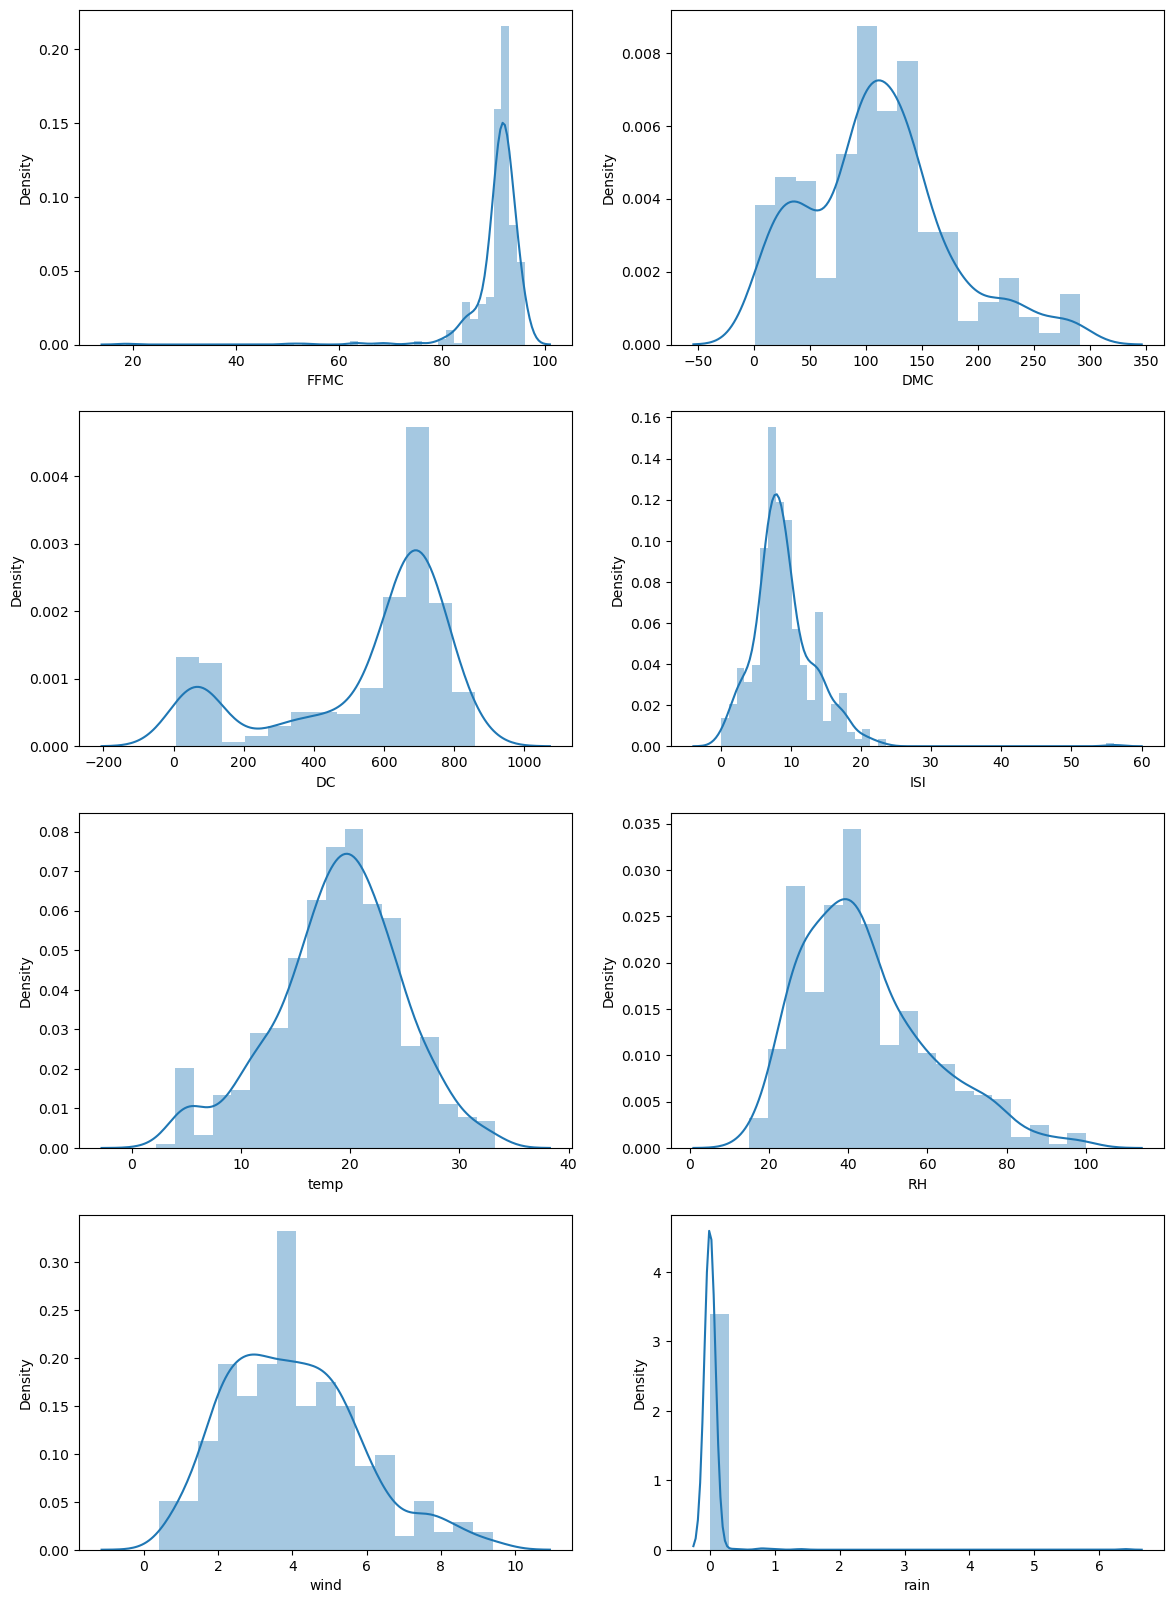

In [18]:
fig, ax = plt.subplots(4,2, figsize = (14,20))

sns.distplot(fire_data.FFMC, ax = ax[0,0])
sns.distplot(fire_data.DMC, ax = ax[0,1])
sns.distplot(fire_data.DC, ax = ax[1,0])
sns.distplot(fire_data.ISI, ax = ax[1,1])
sns.distplot(fire_data.temp, ax = ax[2,0])
sns.distplot(fire_data.RH, ax = ax[2,1])
sns.distplot(fire_data.wind, ax = ax[3,0])
sns.distplot(fire_data.rain, ax = ax[3,1])

plt.show()

In [19]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        Q1 = np.percentile(df[col],25)    # 1st quartile (25%)
        Q3 = np.percentile(df[col],75)    # 3rd quartile (75%)
        IQR = Q3 - Q1                     # Interquartile rrange (IQR)
        
        outlier_step = 1.5 * IQR          # outlier step
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(forest_fire[continuous_feature]))))

The dataset contains 3 observations with more than 2 outliers


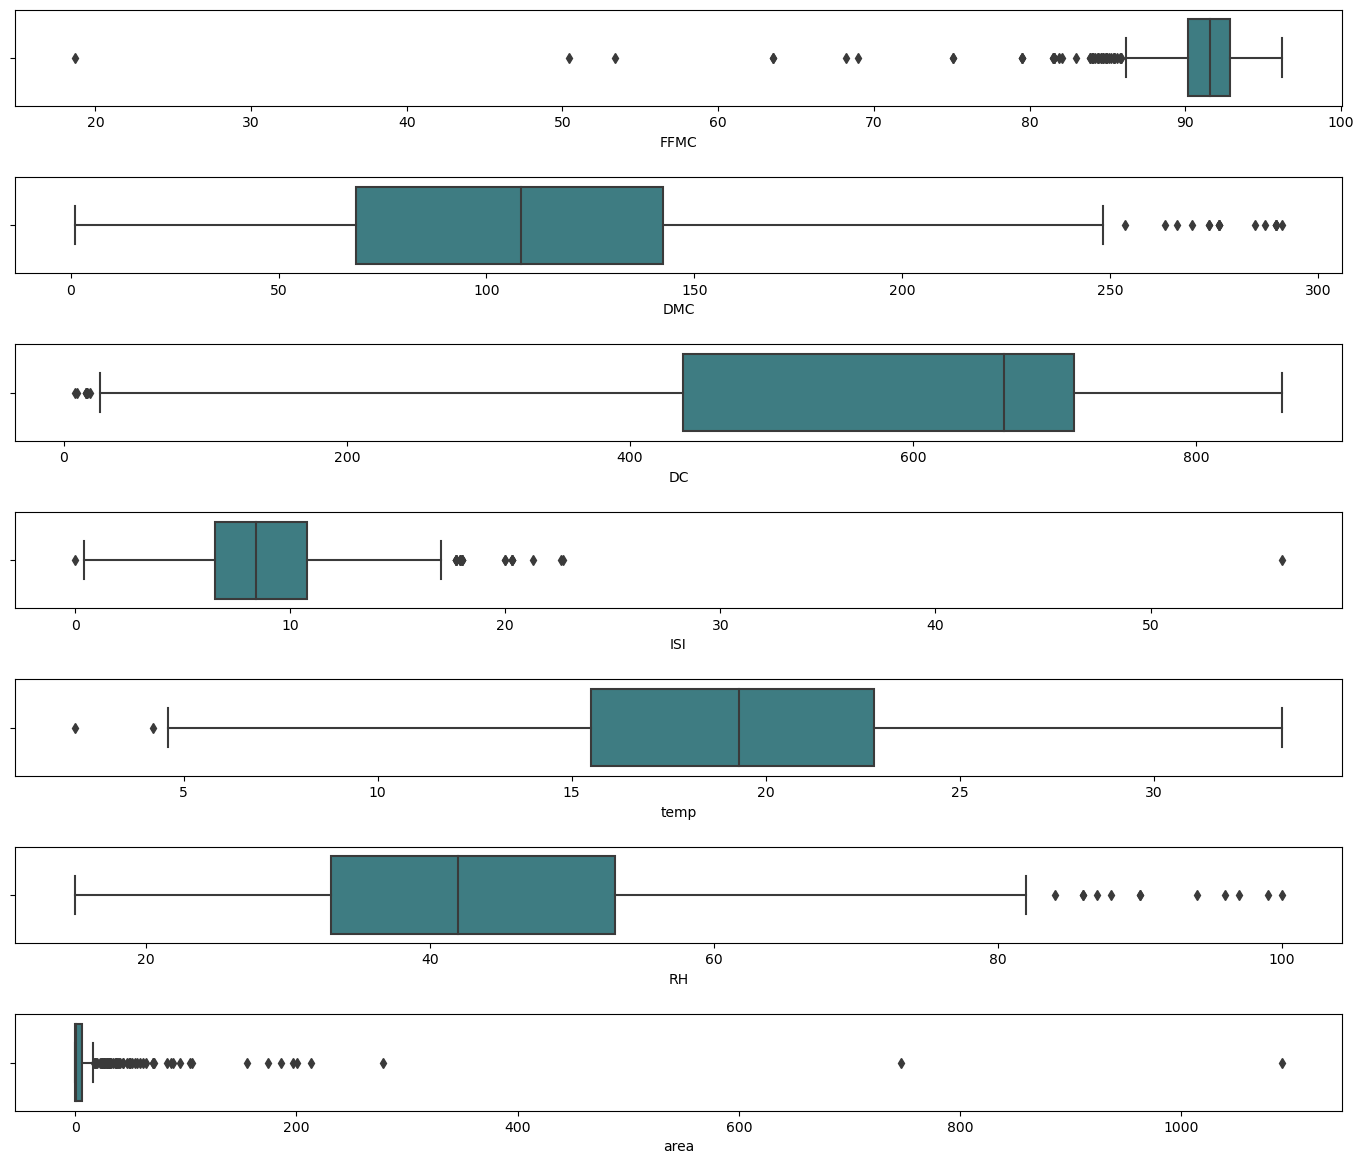

In [20]:
outlier = fire_data.copy() 
fig, axes=plt.subplots(7,1,figsize=(14,12),sharex=False,sharey=False)
sns.boxplot(x='FFMC',data=outlier,palette='crest',ax=axes[0])
sns.boxplot(x='DMC',data=outlier,palette='crest',ax=axes[1])
sns.boxplot(x='DC',data=outlier,palette='crest',ax=axes[2])
sns.boxplot(x='ISI',data=outlier,palette='crest',ax=axes[3])
sns.boxplot(x='temp',data=outlier,palette='crest',ax=axes[4])
sns.boxplot(x='RH',data=outlier,palette='crest',ax=axes[5])
sns.boxplot(x='area',data=outlier,palette='crest',ax=axes[6])
plt.tight_layout(pad=2.0)

In [21]:
#There are lot of outliers present in the dataframe but we can't drop them because they are present in a very large quantity and can be important for model building

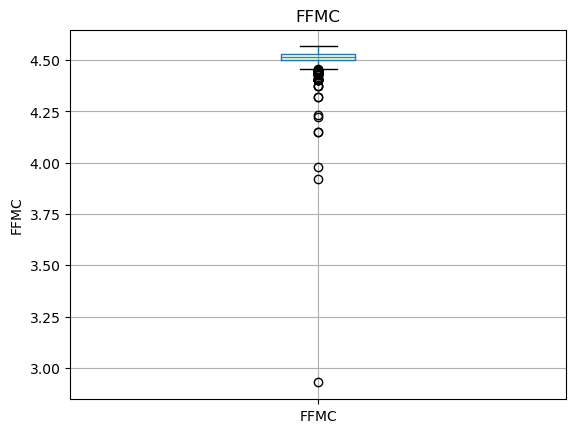

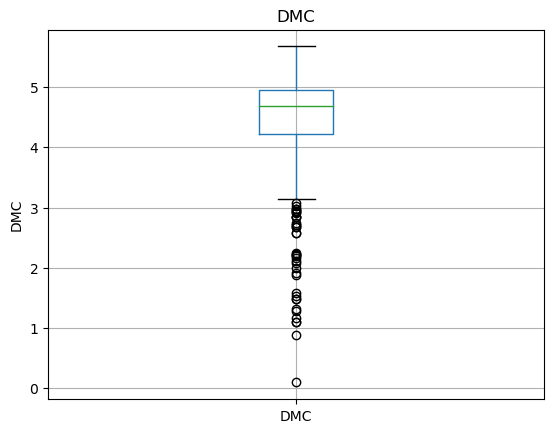

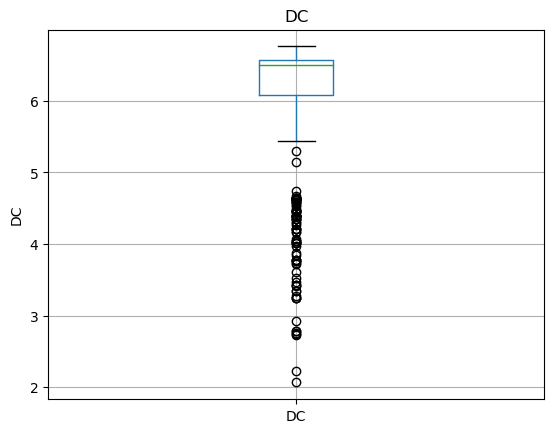

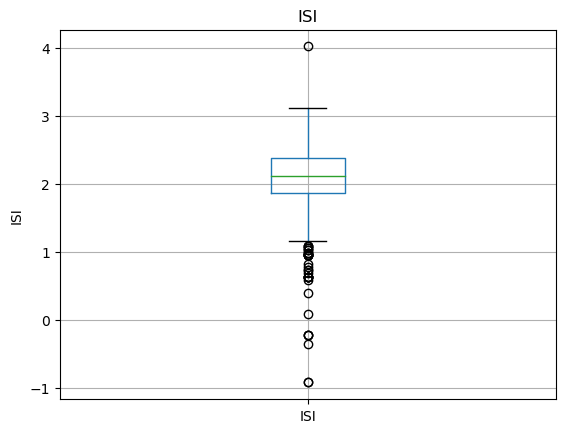

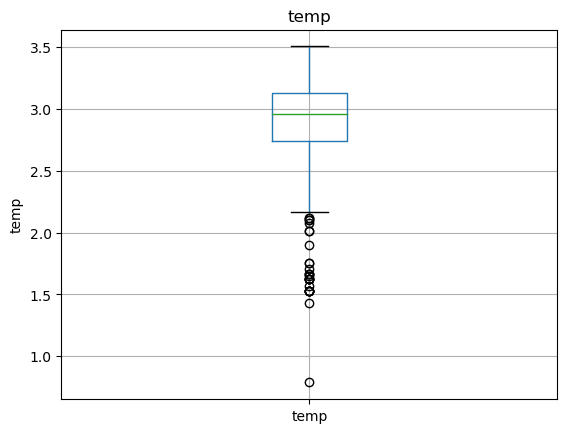

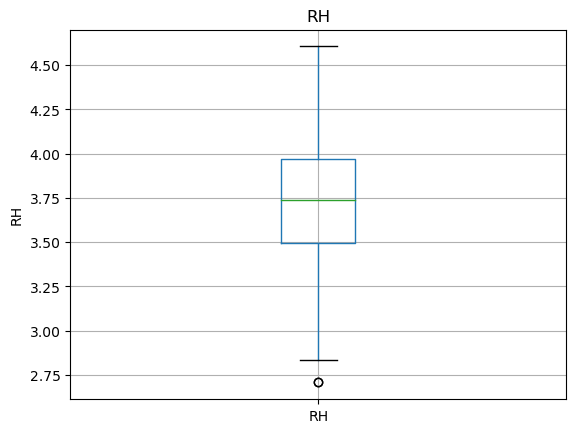

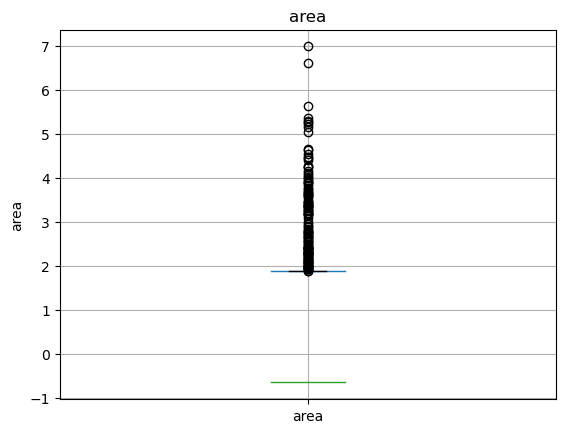

In [22]:
#After Log Transformation
for feature in continuous_feature:
    data = fire_data.copy()
    data[feature]=np.log(data[feature])
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


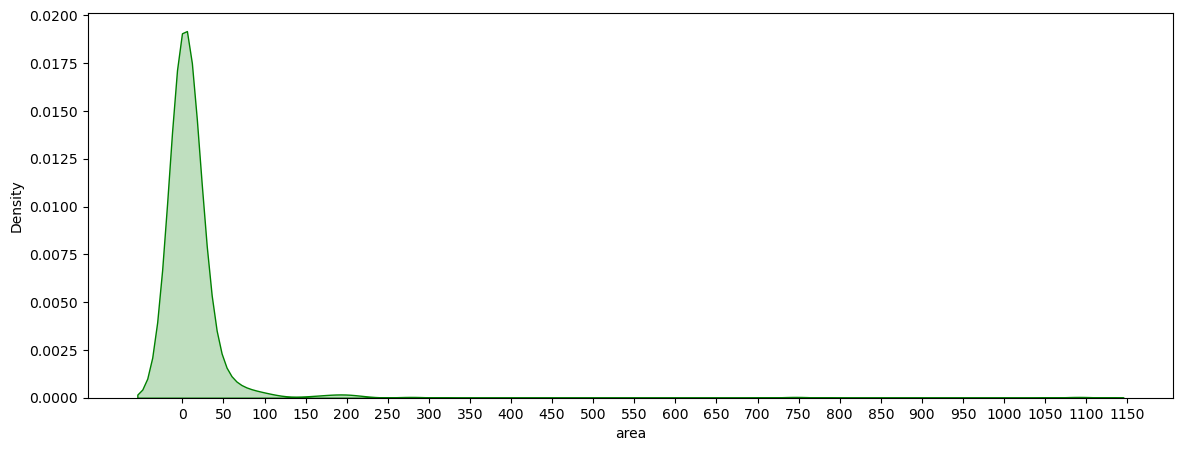

In [23]:
#Visualize the distribution of 'Area' and taking insights
plt.figure(figsize=(14,5))
print("Skew: {}".format(fire_data['area'].skew()))
print("Kurtosis: {}".format(fire_data['area'].kurtosis()))
ax = sns.kdeplot(fire_data['area'],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

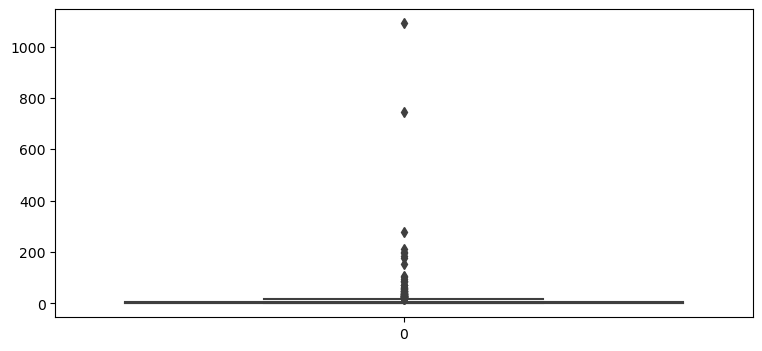

In [24]:
plt.figure(figsize=(9,4))
sns.boxplot(fire_data['area']);

In [25]:
#Categorical variables
categorical_features=[feature for feature in fire_data.columns if fire_data[feature].dtype=='O']
print('Number of Categorical Features:',len(categorical_features), '\n', categorical_features)
forest_fire[categorical_features].head()

Number of Categorical Features: 3 
 ['month', 'day', 'size_category']


,month,day,size_category
0,mar,fri,small
1,oct,tue,small
2,oct,sat,small
3,mar,fri,small
4,mar,sun,small


In [26]:
for feature in categorical_features:
    print("{} number of unique categories in feature named {}".format(len(fire_data[feature].unique()),feature))

12 number of unique categories in feature named month
7 number of unique categories in feature named day
2 number of unique categories in feature named size_category


In [27]:
#Decide which categorical variables you want to use in model

In [28]:
for feature in fire_data.columns:
    if fire_data[feature].dtypes == 'object':      # in pandas it is object
        unique_cat = len(fire_data[feature].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=feature, unique_cat=unique_cat))
        print(fire_data[feature].value_counts())
        print()

Feature 'month' has 12 unique categories
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

Feature 'day' has 7 unique categories
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64

Feature 'size_category' has 2 unique categories
small    378
large    139
Name: size_category, dtype: int64



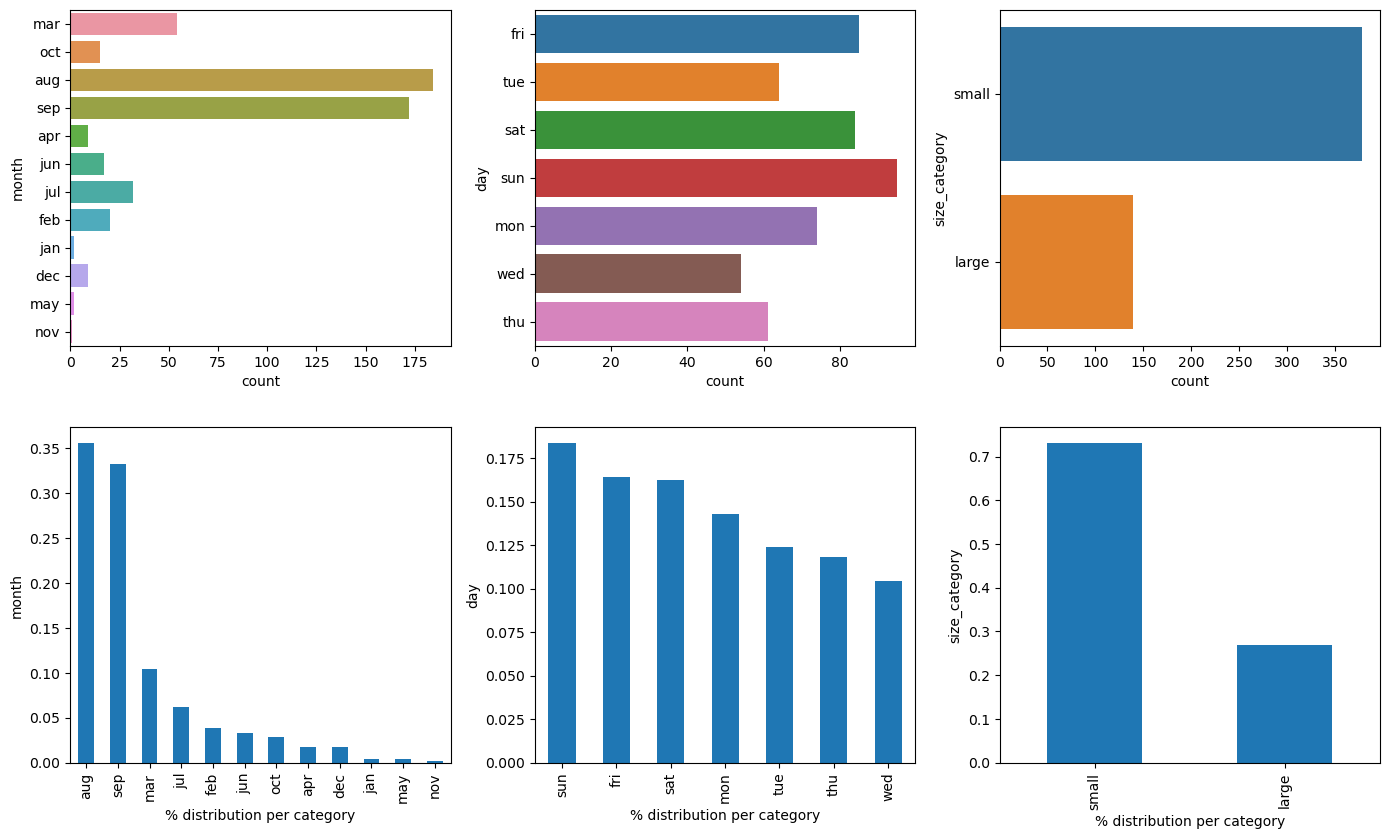

In [29]:
#Analyzing categorical variables
plt.figure(figsize=(14,12))
for i,col in enumerate(categorical_features,1):
    plt.subplot(3,3,i)
    sns.countplot(data = fire_data,y=col)
    plt.subplot(3,3,i+3)
    fire_data[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()

In [30]:
#Analyzing the relationship of categorical features with respect to the Target feature
print(fire_data['area'].describe(),'\n')
# A categorical variable based on forest fire area damage
# No damage, low, moderate, high, very high

df = fire_data.copy()
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64 



,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category,damage_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,small,No damage
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,small,No damage
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,small,No damage
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,small,No damage
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,small,No damage


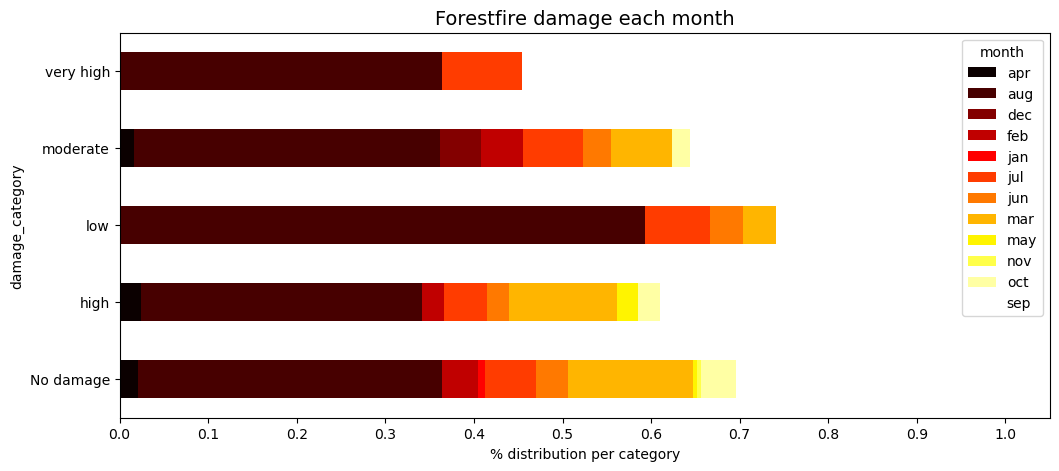

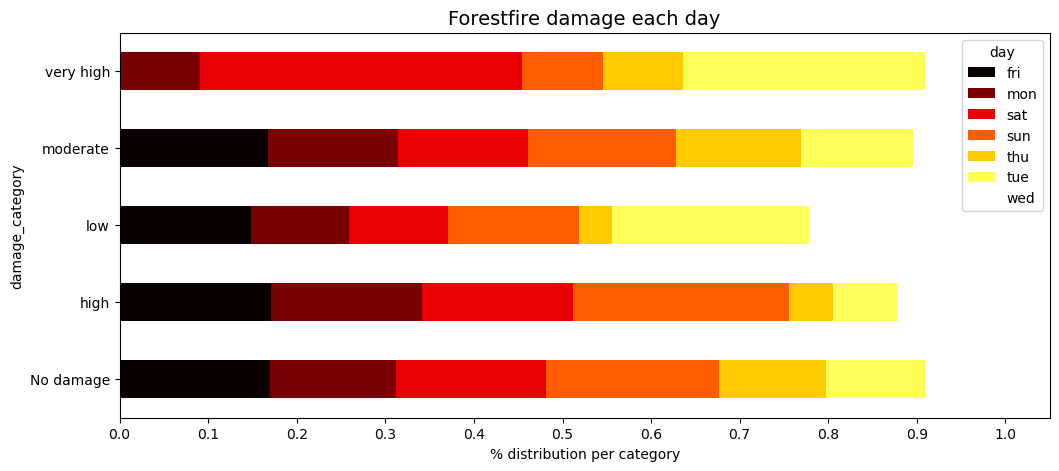

In [31]:
for col in categorical_features:
    if col!="size_category":
        cross = pd.crosstab(index=df['damage_category'],columns=df[col],normalize='index')
        cross.plot.barh(stacked=True,cmap='hot',figsize=(12,5))
        plt.xlabel('% distribution per category')
        plt.xticks(np.arange(0,1.1,0.1))
        plt.title("Forestfire damage each {}".format(col), fontsize=14)
        
plt.show()

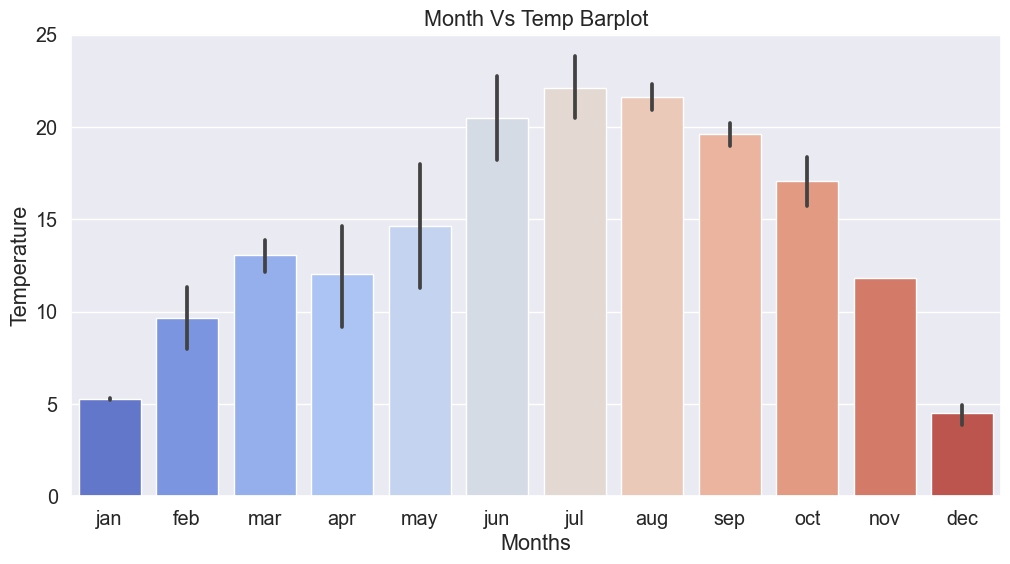

In [32]:
#Setting parameters
plt.rcParams['figure.figsize'] = [12,6]
sns.set(style = "darkgrid", font_scale = 1.3)
month_temp = sns.barplot(x = 'month', y = 'temp', data = fire_data,
                         order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], palette = 'coolwarm')
month_temp.set(title = "Month Vs Temp Barplot", xlabel = "Months", ylabel = "Temperature");

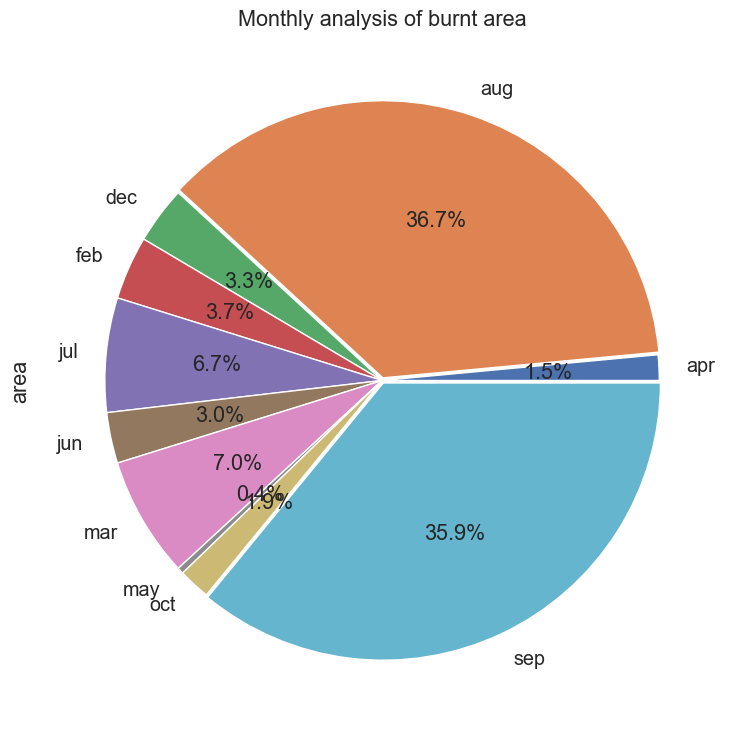

In [33]:
#Monthly analysis of burnt area, where the condition is: area>0
areaburnt = fire_data[fire_data['area']>0]
areaburnt.groupby('month')['area'].agg('count').plot(kind='pie',title='Monthly analysis of burnt area',figsize=(9,9),explode=[0,0.01,0,0,0,0,0,0,0,0.01],autopct='%0.1f%%')
plt.show()

In [34]:
#As we can see from the above pie chart,the month of aug and sep have recorded highest % of forest fire i.e 36.8% & 36.1% respectively.

#Month that recorded least forest fire is may with 0.4%.

In [35]:
#Visualize the Large Forest Fire Size rate by month
df1 = fire_data.copy()
order = {'month':{'jan':'January','feb':'February','mar':'March','apr':'April','may':'May','jun':'June','jul':'July','aug':'August','sep':'September','oct':'October','nov':'November','dec':'December'}}
df1 = df1.replace(order)

count_month_response_pct = pd.crosstab(df1['size_category'],df1['month']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()
month = pd.DataFrame(df1['month'].value_counts())
month['% Small Forest Fire'] = count_month_response_pct['small']
month['% Large Forest Fire'] = count_month_response_pct['large']
month.drop('month',axis = 1,inplace = True)
month['index'] = [8,9,3,7,2,6,10,4,12,1,5,11]
month = month.sort_values('index',ascending = True)
month.drop('index', axis=1,inplace=True)
month

,% Small Forest Fire,% Large Forest Fire
January,100.000000,0.000000
February,70.000000,30.000000
March,77.777778,22.222222
April,77.777778,22.222222
May,50.000000,50.000000
June,82.352941,17.647059
July,71.875000,28.125000
August,76.630435,23.369565
September,70.348837,29.651163
October,73.333333,26.666667


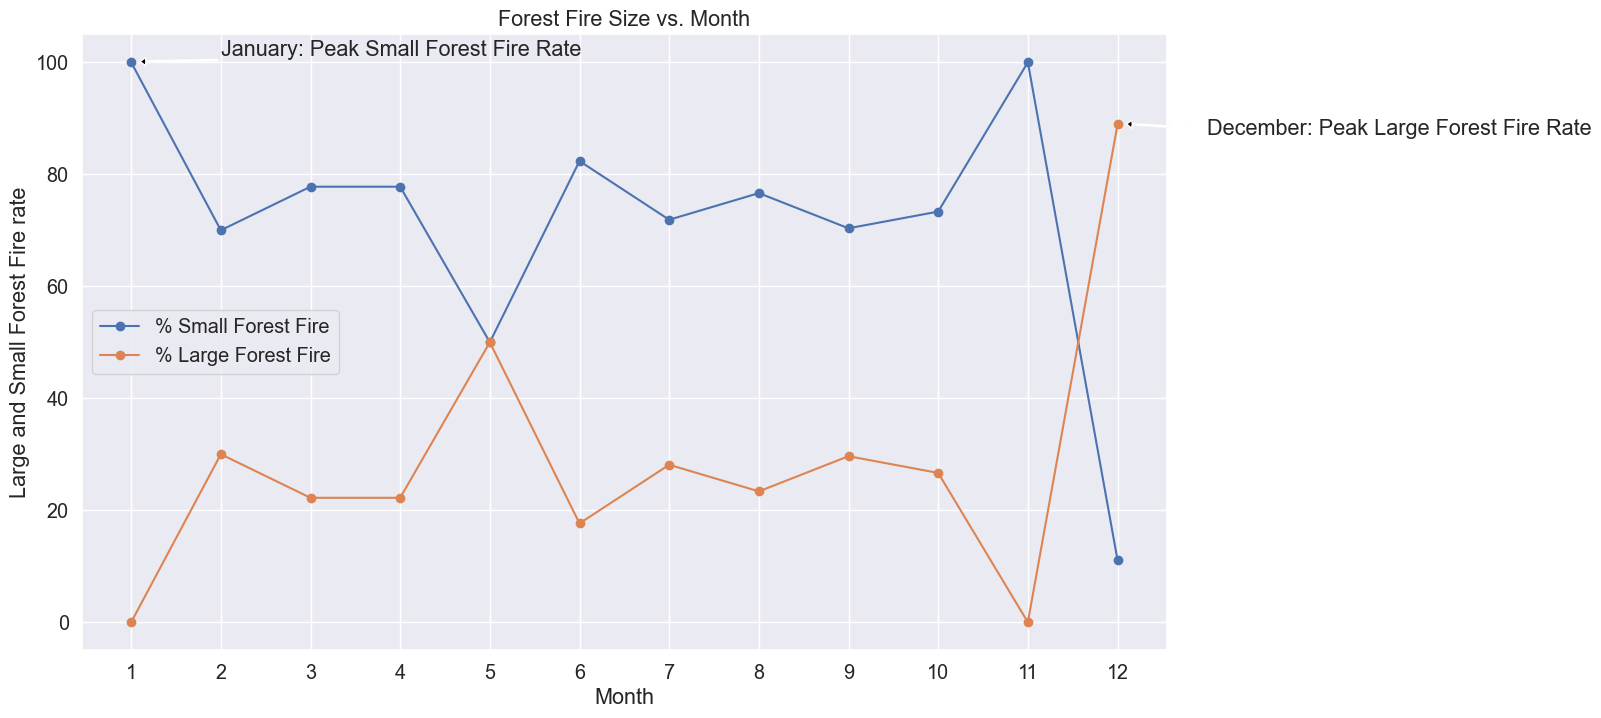

In [36]:
#Change 'month' from words to numbers for easier analysis
df1 = fire_data.copy()
order = {'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}}
df1 = df1.replace(order)

count_month_response_pct = pd.crosstab(df1['size_category'],df1['month']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()
month = pd.DataFrame(df1['month'].value_counts())
month['% Small Forest Fire'] = count_month_response_pct['small']
month['% Large Forest Fire'] = count_month_response_pct['large']
month.drop('month',axis = 1,inplace = True)
month['Month'] = ['August','September','March','July','February','June','October','April','December','January','May','November']
month['index'] = [8,9,3,7,2,6,10,4,12,1,5,11]
month = month.sort_values('index',ascending = True)
month.drop('index', axis=1,inplace=True)
plot_month = month[['% Small Forest Fire','% Large Forest Fire']].plot(kind ='line', figsize = (14,8), marker = 'o')

plt.title('Forest Fire Size vs. Month')
plt.ylabel('Large and Small Forest Fire rate')
plt.xlabel('Month')

ticks = np.arange(1,13,1)
plt.xticks(ticks)

# Annotation: peak of Small fire rate
y = month['% Small Forest Fire'].max()
x = month['% Small Forest Fire'].idxmax()
plt.annotate('January: Peak Small Forest Fire Rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+4), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

# Annotation: peak of large fire rate
y = month['% Large Forest Fire'].max()
x = month['% Large Forest Fire'].idxmax()
plt.annotate('December: Peak Large Forest Fire Rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+1), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

plt.show()

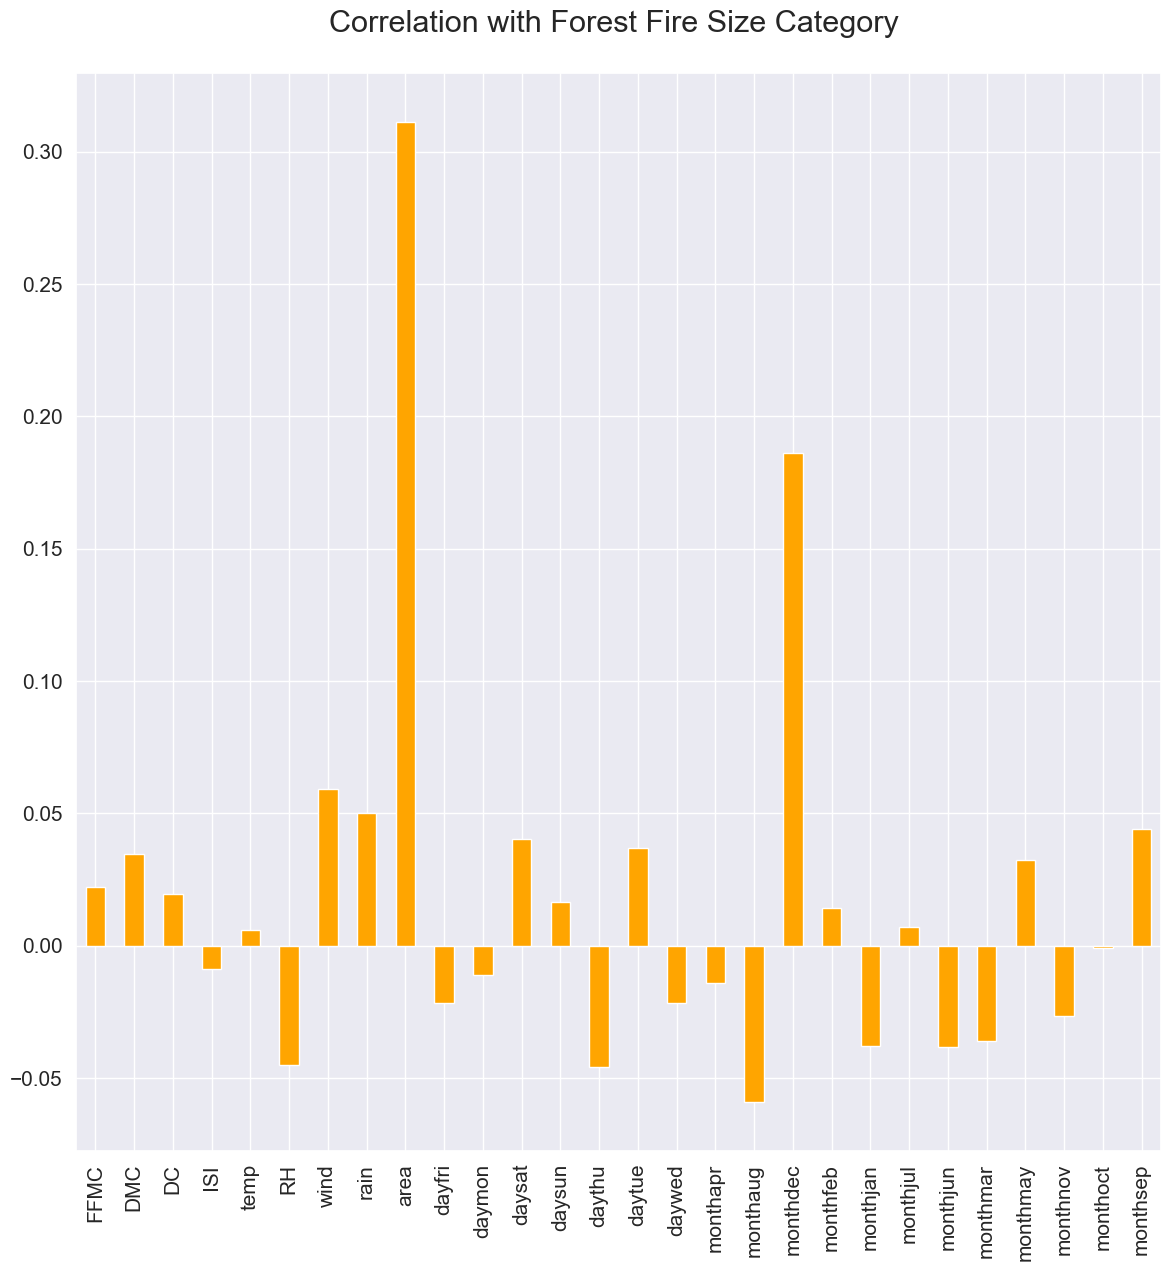

In [37]:
df = fire_data.copy()
df['size_category'] = np.where(df['size_category'].str.contains("large"), 1, 0)

correlations = forest_fire.corrwith(df.size_category)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(figsize= (14,14), fontsize = 15, color = 'orange', rot = 90, grid = True)
plt.title('Correlation with Forest Fire Size Category \n', horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif");

In [38]:
fire_data.size_category.unique()

array(['small', 'large'], dtype=object)

In [39]:
#Checking for Imbalanced or balanced dataset with regards to the Target
countsizesmall = len(fire_data[fire_data.size_category == 'small'])
countsizelarge = len(fire_data[fire_data.size_category == 'large'])
print("Percentage of Small Forest Fire Size: {:.2f}%".format((countsizesmall / (len(fire_data.size_category))*100)))
print("Percentage of Large Foreset Fire Size: {:.2f}%".format((countsizelarge / (len(fire_data.size_category))*100)))

Percentage of Small Forest Fire Size: 73.11%
Percentage of Large Foreset Fire Size: 26.89%


In [40]:
fire_data.size_category.value_counts()

small    378
large    139
Name: size_category, dtype: int64

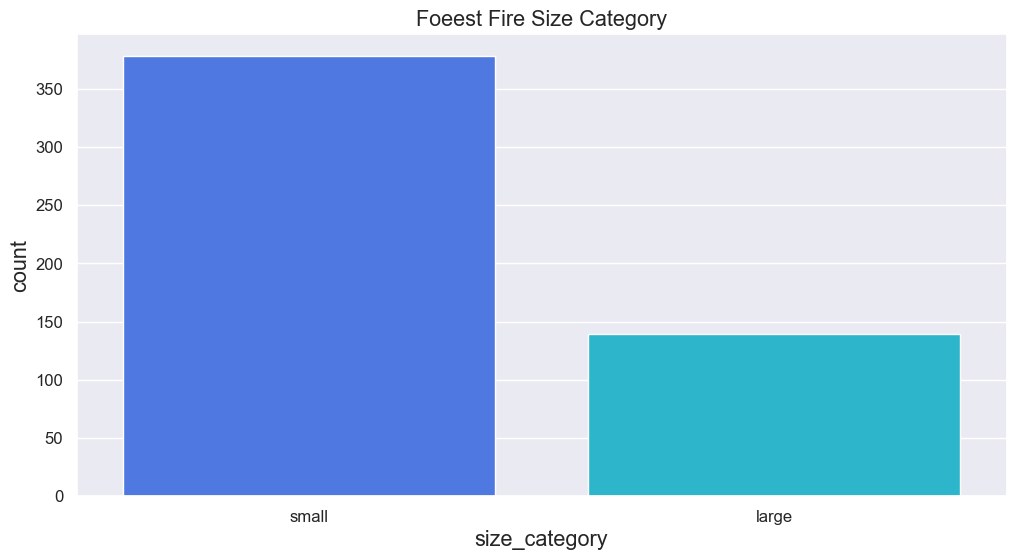

In [41]:
pal = sns.color_palette('rainbow')
sns.countplot(x='size_category', data= fire_data, palette = pal, order= fire_data['size_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Foeest Fire Size Category');

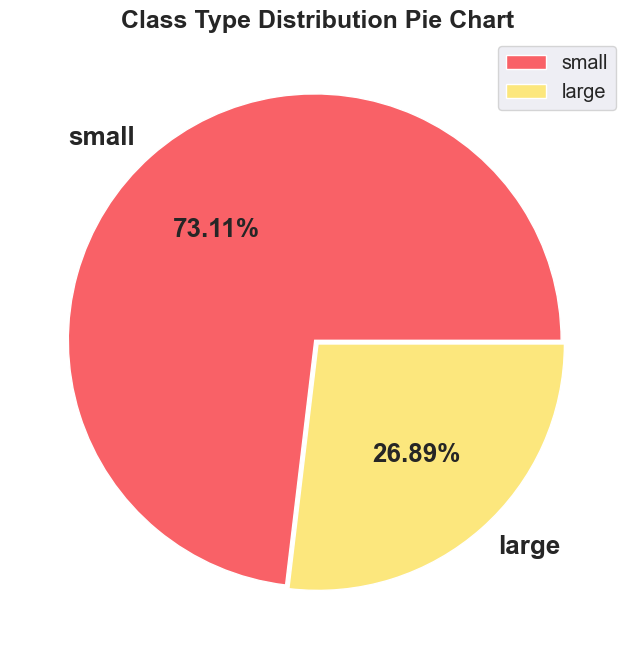

In [42]:
plt.figure(figsize = (8,8))
plt.pie(fire_data['size_category'].value_counts(), labels= fire_data.size_category.unique(),
        explode = [0.02,0.0], autopct= '%.2f%%', colors = ["#F96167", "#FCE77D"],
        textprops = {'size':'large', 'fontweight':'bold',})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

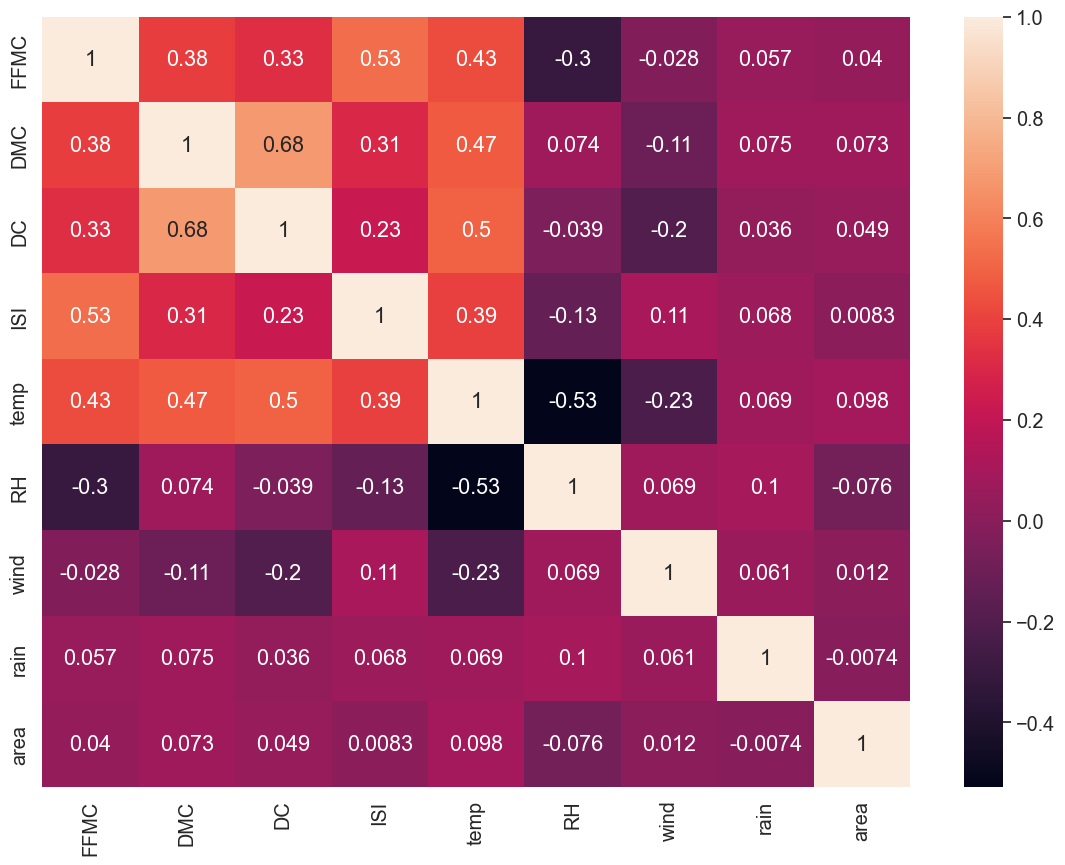

In [43]:
fig= plt.figure(figsize=(14,10))
sns.heatmap(fire_data.corr(), annot=True);
plt.xticks(rotation=90);

# Data Pre-Processing

In [44]:
#Feature Engineering

In [45]:
continuous_feature=[feature for feature in fire_data.columns if fire_data[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 9


In [46]:
fire_data[continuous_feature]

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [47]:
df_standard_scaled = fire_data.copy()
features = df_standard_scaled[continuous_feature]

In [48]:
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,mar,fri,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.20202,small
1,oct,tue,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.20202,small
2,oct,sat,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.20202,small
3,mar,fri,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.20202,small
4,mar,sun,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.20202,small


In [49]:
print('Mean' '\n',np.round(df_standard_scaled.mean(),1))


Mean
 FFMC   -0.0
DMC    -0.0
DC      0.0
ISI     0.0
temp    0.0
RH      0.0
wind   -0.0
rain   -0.0
area    0.0
dtype: float64


In [50]:
print('Standard Devaition','\n',np.round(df_standard_scaled.std()),1)

Standard Devaition 
 FFMC    1.0
DMC     1.0
DC      1.0
ISI     1.0
temp    1.0
RH      1.0
wind    1.0
rain    1.0
area    1.0
dtype: float64 1


In [51]:
df = df_standard_scaled.copy()
df.drop('size_category',axis=1, inplace =True)
df = pd.get_dummies(df.iloc[:,:])
df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.20202,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.20202,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.20202,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.20202,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.20202,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [52]:
#Converting Categorical Variable into Label by using Get Dummies FeatureData Pre-Processing
# Converting string value into binary classes such as if "large" than classify it as '1' else 'O'
df['size_category'] = fire_data.size_category
df['size_category'] = np.where(df['size_category'].str.contains("large"), 1, 0)
df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,size_category
0,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.20202,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.20202,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.20202,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.20202,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.20202,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [53]:
df.size_category.unique()

array([0, 1])

# Feature Selection Technique

In [54]:
forest_fire.drop(['month','day','area'] ,axis=1, inplace= True)

In [55]:
data1 = forest_fire.copy()
data1.drop('size_category',axis=1, inplace =True)
data1 = pd.get_dummies(data1.iloc[:,:-1])
data1.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [56]:
data1['size_category'] = df1.size_category
data1.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,small
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,small
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,small
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,small
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,small


In [57]:
le = LabelEncoder()
le.fit(data1["size_category"])
data1["size_category"]=le.transform(data1["size_category"])
data1.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


# Split into input (X) and output (y) variables

In [58]:
X = data1.drop('size_category', axis = 1)
y=  data1.size_category

In [59]:
#Feature Extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, y)

In [60]:
#Summarize score
scores = fit.scores_
features = fit.transform(X)
score_df = pd.DataFrame(list(zip(scores, X.columns)), columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
1,23.006108,DMC
2,21.872657,DC
17,17.601210,monthdec
5,6.350054,RH
7,5.216072,rain
6,1.440661,wind
16,1.157358,monthaug
12,0.964276,daythu
21,0.738170,monthjun
19,0.735450,monthjan


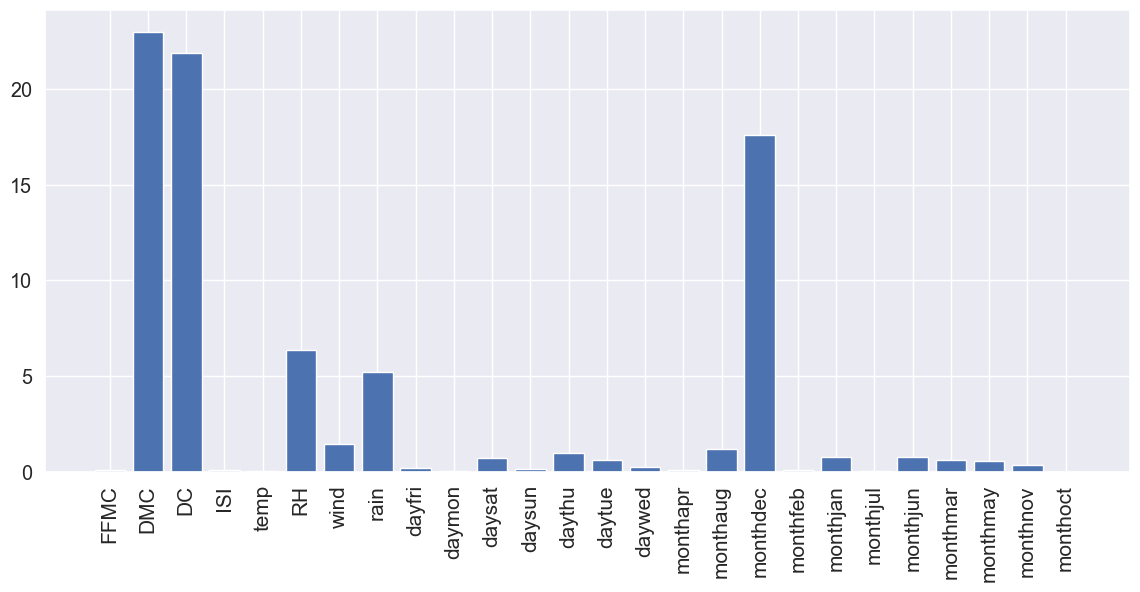

In [61]:
fig, axes = plt.subplots(figsize=(14,6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks(range(len(scores)))
axes.set_xticklabels(X.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

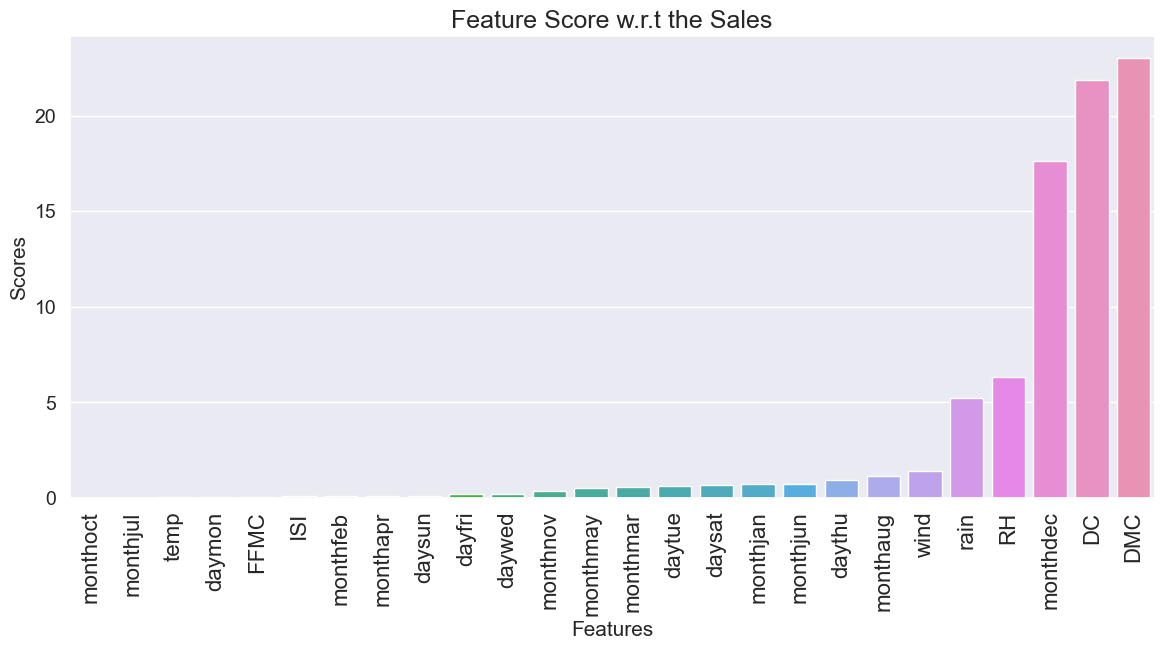

In [62]:
plt.figure(figsize=(14,6))
sns.barplot(x= 'Feature', y= "Score", data= score_df, order= score_df.sort_values('Score').Feature)
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

In [63]:
model_data=df[['DMC','DC','RH','rain','wind','area','month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep','size_category']]
model_data

,DMC,DC,RH,rain,wind,area,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,size_category
0,-1.323326,-1.830477,0.411724,-0.073268,1.498614,-0.202020,0,0,0,0,0,0,0,1,0,0,0,0,0
1,-1.179541,0.488891,-0.692456,-0.073268,-1.741756,-0.202020,0,0,0,0,0,0,0,0,0,0,1,0,0
2,-1.049822,0.560715,-0.692456,-0.073268,-1.518282,-0.202020,0,0,0,0,0,0,0,0,0,0,1,0,0
3,-1.212361,-1.898266,3.233519,0.603155,-0.009834,-0.202020,0,0,0,0,0,0,0,1,0,0,0,0,0
4,-0.931043,-1.798600,3.356206,-0.073268,-1.238940,-0.202020,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,-0.846648,0.474768,-0.753800,-0.073268,-0.736124,-0.100753,0,1,0,0,0,0,0,0,0,0,0,0,1
513,-0.846648,0.474768,1.638592,-0.073268,0.995798,0.651674,0,1,0,0,0,0,0,0,0,0,0,0,1
514,-0.846648,0.474768,1.577248,-0.073268,1.498614,-0.026532,0,1,0,0,0,0,0,0,0,0,0,0,1
515,0.549003,0.269382,-0.140366,-0.073268,-0.009834,-0.202020,0,1,0,0,0,0,0,0,0,0,0,0,0


# Test Train Split With Imbalanced Dataset

In [64]:
x = model_data.drop('size_category',axis=1)
y = model_data[['size_category']]

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3, stratify=y)
len(x_train.columns)

18

# Hyperparameter Tuning

In [66]:
#Hyperparameter Tuning: Optimal Learning rate ,Number of Layers and Neurons

In [67]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=100, step=32), activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [68]:
tuner = RandomSearch(build_model, objective= 'val_accuracy', max_trials= 5, 
                     executions_per_trial=3, directory= 'project', project_name= 'Forest Fire')
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [69]:
tuner.search(x_train, y_train, epochs= 100, validation_data= (x_test, y_test))

Trial 5 Complete [00h 00m 42s]
val_accuracy: 0.9529914657274882

Best val_accuracy So Far: 0.9871794780095419
Total elapsed time: 00h 04m 23s
INFO:tensorflow:Oracle triggered exit


In [70]:
tuner.results_summary()

Results summary
Results in project\Forest Fire
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
num_layers: 4
units_0: 96
units_1: 64
learning_rate: 0.01
units_2: 96
units_3: 64
units_4: 96
units_5: 32
units_6: 32
units_7: 32
units_8: 64
units_9: 32
units_10: 32
units_11: 64
units_12: 32
units_13: 64
units_14: 96
units_15: 64
units_16: 96
units_17: 64
units_18: 32
Score: 0.9871794780095419

Trial 0 summary
Hyperparameters:
num_layers: 19
units_0: 96
units_1: 64
learning_rate: 0.01
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
units_14: 32
units_15: 32
units_16: 32
units_17: 32
units_18: 32
Score: 0.9829059640566508

Trial 4 summary
Hyperparameters:
num_layers: 6
units_0: 32
units_1: 32
learning_rate: 0.001
units_2: 32
units_3: 32
units_4: 64
units_5: 32
units_6: 96
units_7: 96
units_8: 32
units_9: 32
units_10: 32
units_11: 32
unit

In [71]:
#Hyperparameter Tuning: Optimal Batch_size, Number of Epochs

In [72]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(64,input_dim=18,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(units=1,activation="sigmoid"))
    
    adam = Adam(learning_rate=0.01)
    model1.compile(loss='binary_crossentropy',optimizer = adam,metrics=["accuracy"])
    return model1

In [73]:
model1 = KerasClassifier(build_fn= create_model, verbose=0)
batch_size = [10,20,40,50]
epochs = [10,50,100,200]
param_grid = dict(batch_size= batch_size, epochs=epochs)
grid = GridSearchCV(estimator= model1, param_grid= param_grid, cv= KFold(), verbose= 10)

In [74]:
grid_result = grid.fit(x_test,y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START batch_size=10, epochs=10...................................
[CV 1/5; 1/16] END ....batch_size=10, epochs=10;, score=0.906 total time=   1.6s
[CV 2/5; 1/16] START batch_size=10, epochs=10...................................
[CV 2/5; 1/16] END ....batch_size=10, epochs=10;, score=0.968 total time=   1.6s
[CV 3/5; 1/16] START batch_size=10, epochs=10...................................
[CV 3/5; 1/16] END ....batch_size=10, epochs=10;, score=0.839 total time=   1.9s
[CV 4/5; 1/16] START batch_size=10, epochs=10...................................
[CV 4/5; 1/16] END ....batch_size=10, epochs=10;, score=0.935 total time=   1.8s
[CV 5/5; 1/16] START batch_size=10, epochs=10...................................
[CV 5/5; 1/16] END ....batch_size=10, epochs=10;, score=0.935 total time=   1.4s
[CV 1/5; 2/16] START batch_size=10, epochs=50...................................
[CV 1/5; 2/16] END ....batch_size=10, epochs=50;

[CV 3/5; 9/16] END ....batch_size=40, epochs=10;, score=0.903 total time=   1.0s
[CV 4/5; 9/16] START batch_size=40, epochs=10...................................
[CV 4/5; 9/16] END ....batch_size=40, epochs=10;, score=0.839 total time=   1.4s
[CV 5/5; 9/16] START batch_size=40, epochs=10...................................
[CV 5/5; 9/16] END ....batch_size=40, epochs=10;, score=0.935 total time=   1.0s
[CV 1/5; 10/16] START batch_size=40, epochs=50..................................
[CV 1/5; 10/16] END ...batch_size=40, epochs=50;, score=0.812 total time=   1.4s
[CV 2/5; 10/16] START batch_size=40, epochs=50..................................
[CV 2/5; 10/16] END ...batch_size=40, epochs=50;, score=1.000 total time=   1.6s
[CV 3/5; 10/16] START batch_size=40, epochs=50..................................
[CV 3/5; 10/16] END ...batch_size=40, epochs=50;, score=0.903 total time=   1.8s
[CV 4/5; 10/16] START batch_size=40, epochs=50..................................
[CV 4/5; 10/16] END ...batch

In [75]:
print('Best {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{}, {} with {}".format(mean,stdev,param))

Best 0.9556451559066772, using {'batch_size': 20, 'epochs': 100}
0.9167338609695435, 0.04359503429863503 with {'batch_size': 10, 'epochs': 10}
0.9556451439857483, 0.04221371222927085 with {'batch_size': 10, 'epochs': 50}
0.94919353723526, 0.04233678433220251 with {'batch_size': 10, 'epochs': 100}
0.94919353723526, 0.04233678433220251 with {'batch_size': 10, 'epochs': 200}
0.8915322542190551, 0.046193558676938334 with {'batch_size': 20, 'epochs': 10}
0.94919353723526, 0.04233678433220251 with {'batch_size': 20, 'epochs': 50}
0.9556451559066772, 0.04688529464881791 with {'batch_size': 20, 'epochs': 100}
0.9491935253143311, 0.03709676265716553 with {'batch_size': 20, 'epochs': 200}
0.9104838609695435, 0.05495718495477339 with {'batch_size': 40, 'epochs': 10}
0.9302419185638428, 0.06674087097532069 with {'batch_size': 40, 'epochs': 50}
0.9491935253143311, 0.03709676265716553 with {'batch_size': 40, 'epochs': 100}
0.9427419185638428, 0.03610164807752721 with {'batch_size': 40, 'epochs': 200

In [76]:
#Hyperparameter Tuning: Optimal Droupout rate
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(64,input_dim=18,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(units=1,activation="sigmoid"))
    
    adam=Adam(lr=0.01)
    model2.compile(loss='binary_crossentropy',optimizer = adam,metrics=["accuracy"])
    return model2

In [77]:
model2=KerasClassifier(build_fn=create_model,batch_size=10,epochs=100,verbose=0)
dropout_rate=[0.0,0.1,0.2,0.3,0.4,0.5]
param_grid=dict(dropout_rate=dropout_rate)
grid2 = GridSearchCV(estimator=model2,param_grid=param_grid,cv=KFold(),verbose=10)

In [78]:
grid_result2 = grid2.fit(x_test,y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................
[CV 1/5; 1/6] END .............dropout_rate=0.0;, score=0.875 total time=   5.4s
[CV 2/5; 1/6] START dropout_rate=0.0............................................
[CV 2/5; 1/6] END .............dropout_rate=0.0;, score=1.000 total time=   4.1s
[CV 3/5; 1/6] START dropout_rate=0.0............................................
[CV 3/5; 1/6] END .............dropout_rate=0.0;, score=0.968 total time=   4.6s
[CV 4/5; 1/6] START dropout_rate=0.0............................................
[CV 4/5; 1/6] END .............dropout_rate=0.0;, score=0.968 total time=   4.3s
[CV 5/5; 1/6] START dropout_rate=0.0............................................
[CV 5/5; 1/6] END .............dropout_rate=0.0;, score=0.968 total time=   3.7s
[CV 1/5; 2/6] START dropout_rate=0.1............................................
[CV 1/5; 2/6] END .............dropout_rate=0.1;,

In [79]:
print('Best {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best 0.9620967626571655, using {'dropout_rate': 0.3}
0.9556451439857483,0.04221371222927085 with {'dropout_rate': 0.0}
0.9427419185638428,0.04621467185265233 with {'dropout_rate': 0.1}
0.94919353723526,0.04233678433220251 with {'dropout_rate': 0.2}
0.9620967626571655,0.04587568455888755 with {'dropout_rate': 0.3}
0.9491935253143311,0.03709676265716553 with {'dropout_rate': 0.4}
0.9362903118133545,0.044493916768407756 with {'dropout_rate': 0.5}


In [80]:
#Hyperparameter Tuning: Optimal Activation Function and Kernel Initializer
def create_model(activation_function,init):
    model3 = Sequential()
    model3.add(Dense(64,input_dim=18,activation='relu'))
    model3.add(Dropout(0.0))
    model3.add(Dense(64,activation='relu'))
    model3.add(Dropout(0.0))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.0))
    model3.add(Dense(units=1,activation="sigmoid"))
    
    adam = Adam(lr=0.01)
    model3.compile(loss='binary_crossentropy', optimizer = adam, metrics=["accuracy"])
    return model3

In [81]:
model3 = KerasClassifier(build_fn=create_model,batch_size=10,epochs=100,verbose=0)
activation_function = ['softmax','tanh','relu']
init = ['normal','uniform','zero']
param_grid = dict(activation_function= activation_function, init= init)
grid3 = GridSearchCV(estimator= model3, param_grid= param_grid, cv= KFold(), verbose=10) 

In [82]:
grid_result3 = grid3.fit(x_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START activation_function=softmax, init=normal....................
[CV 1/5; 1/9] END activation_function=softmax, init=normal;, score=0.875 total time=   6.4s
[CV 2/5; 1/9] START activation_function=softmax, init=normal....................
[CV 2/5; 1/9] END activation_function=softmax, init=normal;, score=0.968 total time=   4.1s
[CV 3/5; 1/9] START activation_function=softmax, init=normal....................
[CV 3/5; 1/9] END activation_function=softmax, init=normal;, score=0.935 total time=   4.7s
[CV 4/5; 1/9] START activation_function=softmax, init=normal....................
[CV 4/5; 1/9] END activation_function=softmax, init=normal;, score=1.000 total time=   4.4s
[CV 5/5; 1/9] START activation_function=softmax, init=normal....................
[CV 5/5; 1/9] END activation_function=softmax, init=normal;, score=0.968 total time=   5.7s
[CV 1/5; 2/9] START activation_function=softmax, init=uniform..............

In [83]:
print('Best {}, using {}'.format(grid_result3.best_score_, grid_result3.best_params_))
means = grid_result3.cv_results_["mean_test_score"]
stds = grid_result3.cv_results_["std_test_score"]
params = grid_result3.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean, stdev, param))

Best 0.9683467626571656, using {'activation_function': 'relu', 'init': 'zero'}
0.94919353723526,0.04233678433220251 with {'activation_function': 'softmax', 'init': 'normal'}
0.9493951439857483,0.05427993920407009 with {'activation_function': 'softmax', 'init': 'uniform'}
0.9556451439857483,0.04221371222927085 with {'activation_function': 'softmax', 'init': 'zero'}
0.9556451439857483,0.04221371222927085 with {'activation_function': 'tanh', 'init': 'normal'}
0.9556451559066772,0.04688529464881791 with {'activation_function': 'tanh', 'init': 'uniform'}
0.94919353723526,0.04233678433220251 with {'activation_function': 'tanh', 'init': 'zero'}
0.94294353723526,0.053629026870083876 with {'activation_function': 'relu', 'init': 'normal'}
0.9620967626571655,0.04587568455888755 with {'activation_function': 'relu', 'init': 'uniform'}
0.9683467626571656,0.03423622205401736 with {'activation_function': 'relu', 'init': 'zero'}


# Building Neural Networks Model using Optimal Values

In [84]:
#Initialising the ANN
def toFindBestParams(x_train, y_train, x_test, y_test):

    # Defining list of hyperparameters
    batch_size_list = [5 , 10 , 15 , 20 ]
    epoch_list      = [5 , 10 , 50 , 100]
           
    # Initializing the trials
    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:
            
            # Create ANN model
            model = Sequential()
            
            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=x_train.shape[1], kernel_initializer='normal', activation='tanh'))
            
            # Defining the Second layer of the model
            model.add(Dense(units=6, kernel_initializer='normal', activation='tanh'))
 
            # The output neuron is a single fully connected node Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
 
            # Compiling the model
            model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy'])
 
            # Fitting the ANN to the Training set
            model_trained = model.fit(x_train, y_train ,batch_size = batch_trial, epochs = epochs_trial, verbose=0)
               
            # Fetching the accuracy of the training
            Accuracy_train = model_trained.history['accuracy'][-1]   
            
            # Printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:',epochs_trial, 'Accuracy:',Accuracy_train)

# Calling the function
toFindBestParams(x_train, y_train, x_test, y_test)

batch_size: 5 - epochs: 5 Accuracy: 0.8393352031707764
batch_size: 5 - epochs: 10 Accuracy: 0.950138509273529
batch_size: 5 - epochs: 50 Accuracy: 0.9889196753501892
batch_size: 5 - epochs: 100 Accuracy: 0.9944598078727722
batch_size: 10 - epochs: 5 Accuracy: 0.7811634540557861
batch_size: 10 - epochs: 10 Accuracy: 0.880886435508728
batch_size: 10 - epochs: 50 Accuracy: 0.9916897416114807
batch_size: 10 - epochs: 100 Accuracy: 1.0
batch_size: 15 - epochs: 5 Accuracy: 0.7590027451515198
batch_size: 15 - epochs: 10 Accuracy: 0.81717449426651
batch_size: 15 - epochs: 50 Accuracy: 0.9916897416114807
batch_size: 15 - epochs: 100 Accuracy: 0.9916897416114807
batch_size: 20 - epochs: 5 Accuracy: 0.7590027451515198
batch_size: 20 - epochs: 10 Accuracy: 0.7756232619285583
batch_size: 20 - epochs: 50 Accuracy: 0.9889196753501892
batch_size: 20 - epochs: 100 Accuracy: 0.9972299337387085


In [85]:
#Training Model
# create ANN model
model = Sequential()

# Defining the first layer of the model
model.add(Dense(units=50, input_dim=x_train.shape[1], kernel_initializer='normal', activation='tanh'))

# Defining the Second layer of the model
model.add(Dense(units=6, kernel_initializer='normal', activation='tanh'))
    
# The output neuron is a single fully connected node Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])

# Training the model with best parameters
history = model.fit(x_train, y_train, validation_split=0.33, batch_size = 10, epochs = 100)

Epoch 1/100
25/25 [==============================] - 1s 14ms/step - loss: 0.6854 - accuracy: 0.7178 - val_loss: 0.6792 - val_accuracy: 0.7000
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6597 - accuracy: 0.7676 - val_loss: 0.6516 - val_accuracy: 0.7083
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6078 - accuracy: 0.7718 - val_loss: 0.6080 - val_accuracy: 0.7167
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 0.5509 - accuracy: 0.7718 - val_loss: 0.5780 - val_accuracy: 0.7167
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.5170 - accuracy: 0.7759 - val_loss: 0.5669 - val_accuracy: 0.7250
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4970 - accuracy: 0.7759 - val_loss: 0.5555 - val_accuracy: 0.7417
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 0.4781 - accuracy: 0.7884 - val_loss: 0.5425 - val_accuracy: 0.7417
Epoch 8/100


Epoch 59/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0313 - accuracy: 0.9959 - val_loss: 0.3095 - val_accuracy: 0.9250
Epoch 60/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0297 - accuracy: 0.9959 - val_loss: 0.3017 - val_accuracy: 0.9417
Epoch 61/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0287 - accuracy: 0.9917 - val_loss: 0.3097 - val_accuracy: 0.9417
Epoch 62/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0296 - accuracy: 0.9959 - val_loss: 0.3086 - val_accuracy: 0.9417
Epoch 63/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0282 - accuracy: 0.9959 - val_loss: 0.3156 - val_accuracy: 0.9250
Epoch 64/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0280 - accuracy: 0.9959 - val_loss: 0.3251 - val_accuracy: 0.9167
Epoch 65/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0270 - accuracy: 0.9959 - val_loss: 0.3143 - val_accuracy: 0.9333
Epoch 

In [86]:
#Model Evaluation Train and Test Error
scores = model.evaluate(x, y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

17/17 [==============================] - 0s 2ms/step - loss: 0.1026 - accuracy: 0.9768
accuracy: 97.68%


In [87]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Compare the train-set and test-set accuracy

# Check for overfitting and underfitting

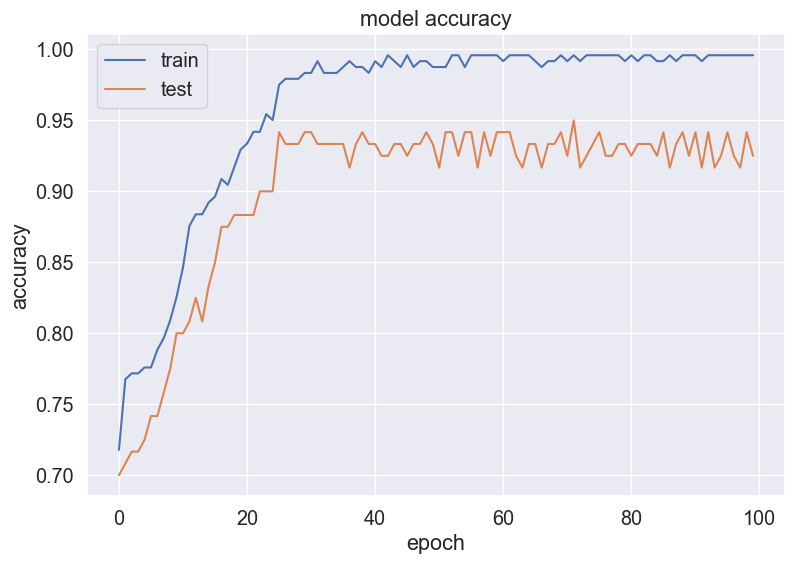

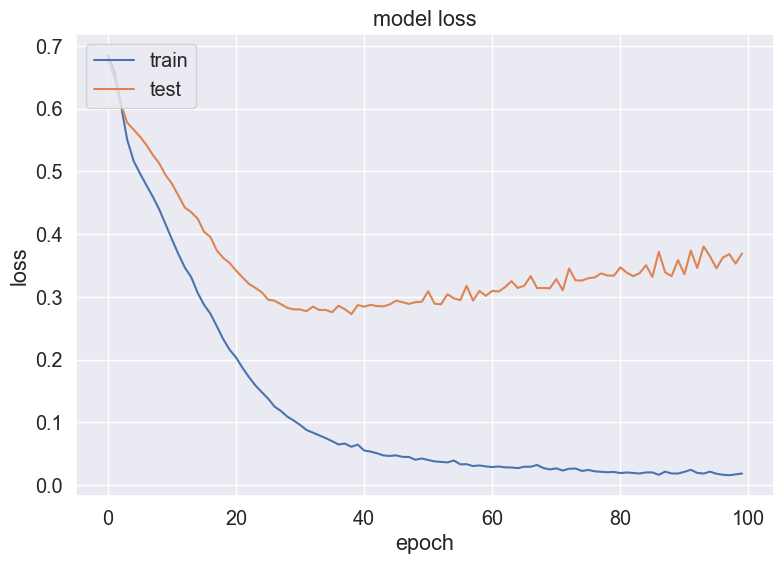

In [88]:
# summarize history for accuracy
plt.figure(figsize=(9,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [89]:
#Predicting values from Model using same dataset

In [90]:
# generating predictions for test data
y_predict_test = model.predict(x_test) 

# creating table with test price & predicted price for test
test_prediction = pd.DataFrame()
test_prediction['Test_Actual'] = y_test.size_category
test_prediction['Test_Probability'] = y_predict_test
def probToBinary(varProb):
    if varProb >= 0.5:
        return 1
    else:
        return 0

# converting the probability of target variable to binary class of test data
test_prediction['Test_Predicted'] = test_prediction['Test_Probability'].apply(probToBinary)
print(test_prediction.shape)
test_prediction.head(10)

5/5 [==============================] - 0s 3ms/step
(156, 3)


,Test_Actual,Test_Probability,Test_Predicted
493,1,0.997901,1
298,0,0.001330,0
93,0,0.001643,0
437,0,0.002008,0
340,0,0.021271,0
7,0,0.001621,0
172,0,0.005336,0
76,0,0.001706,0
148,0,0.002117,0
104,0,0.001356,0


In [91]:
# generating predictions for train data
y_predict_train = model.predict(x_train)

# creating table with test price & predicted price for test
train_prediction = pd.DataFrame()
train_prediction['Train_Actual'] = y_train.size_category
train_prediction['Train_Probability'] = y_predict_train
train_prediction['Train_Predicted'] = train_prediction['Train_Probability'].apply(probToBinary)
print(train_prediction.shape)
train_prediction.head(10)

12/12 [==============================] - 0s 3ms/step
(361, 3)


,Train_Actual,Train_Probability,Train_Predicted
115,0,0.002056,0
130,0,0.001791,0
413,0,0.001968,0
350,0,0.009342,0
103,0,0.001557,0
511,0,0.001712,0
325,0,0.001636,0
473,1,0.997901,1
265,0,0.001727,0
226,1,0.997901,1


# Classification Report

In [92]:
print("Accuracy score for Test Data    = ", np.round(accuracy_score(test_prediction['Test_Actual'],test_prediction['Test_Predicted']),2)*100,"%")
print("Confusion Matrix for Test Data  =\n", confusion_matrix(test_prediction['Test_Actual'],test_prediction['Test_Predicted']))
print("Classification Report for Test Data  =\n", classification_report(test_prediction['Test_Actual'],test_prediction['Test_Predicted']))

Accuracy score for Test Data    =  99.0 %
Confusion Matrix for Test Data  =
 [[112   2]
 [  0  42]]
Classification Report for Test Data  =
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       114
           1       0.95      1.00      0.98        42

    accuracy                           0.99       156
   macro avg       0.98      0.99      0.98       156
weighted avg       0.99      0.99      0.99       156



In [93]:
print("Accuracy score for Train Data    = ", np.round(accuracy_score(train_prediction['Train_Actual'],train_prediction['Train_Predicted']),2)*100,"%")
print("Confusion Matrix for Train Data  =\n", confusion_matrix(train_prediction['Train_Actual'],train_prediction['Train_Predicted']))
print("Classification Report for Train Data  =\n", classification_report(train_prediction['Train_Actual'],train_prediction['Train_Predicted']))

Accuracy score for Train Data    =  97.0 %
Confusion Matrix for Train Data  =
 [[259   5]
 [  5  92]]
Classification Report for Train Data  =
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       264
           1       0.95      0.95      0.95        97

    accuracy                           0.97       361
   macro avg       0.96      0.96      0.96       361
weighted avg       0.97      0.97      0.97       361



# Neural Networks model using Linear Kernel has great predictive power to identify the fire size that would be either small or large int the Forest.

In [94]:
# print the scores on training and test set
y_predict_test = model.predict(x_test) 
y_predict_train = model.predict(x_train)
print('Training set score : {:.2f}%'.format(accuracy_score(train_prediction['Train_Actual'], train_prediction['Train_Predicted'])*100))

print('Test set score     : {:.2f}%'.format(accuracy_score(test_prediction['Test_Actual'], test_prediction['Test_Predicted'])*100))

12/12 [==============================] - 0s 2ms/step
Training set score : 97.23%
Test set score     : 98.72%


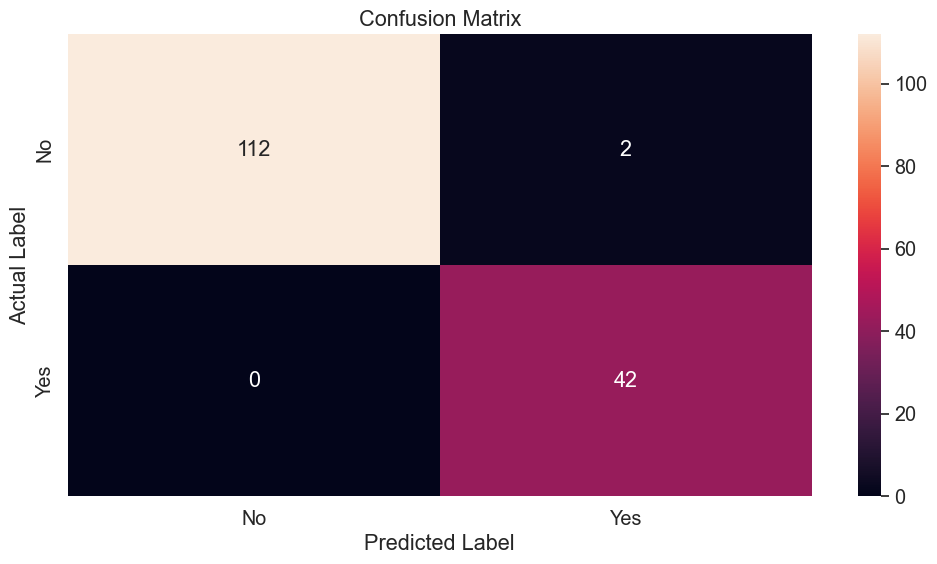

In [95]:
#Confusion Matrix
cm_df = confusion_matrix(test_prediction['Test_Actual'], test_prediction['Test_Predicted'])
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(cm_df, index = class_label, columns = class_label)

sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

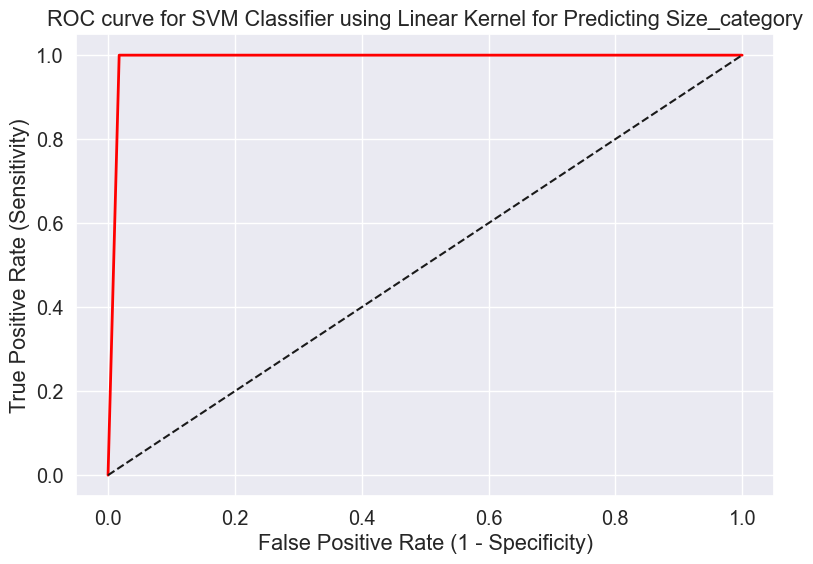

ROC AUC : 0.9912


In [96]:
#ROC - AUC Curve
plt.figure(figsize=(9,6))
fpr, tpr, thresholds = roc_curve(test_prediction['Test_Actual'], test_prediction['Test_Predicted'])
plt.plot(fpr, tpr, linewidth=2, color='red')
plt.plot([0,1], [0,1], 'k--' )
plt.title('ROC curve for SVM Classifier using Linear Kernel for Predicting Size_category')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC_AUC = roc_auc_score(test_prediction['Test_Actual'], test_prediction['Test_Predicted'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

In [97]:
#Plot histogram of predicted probabilities

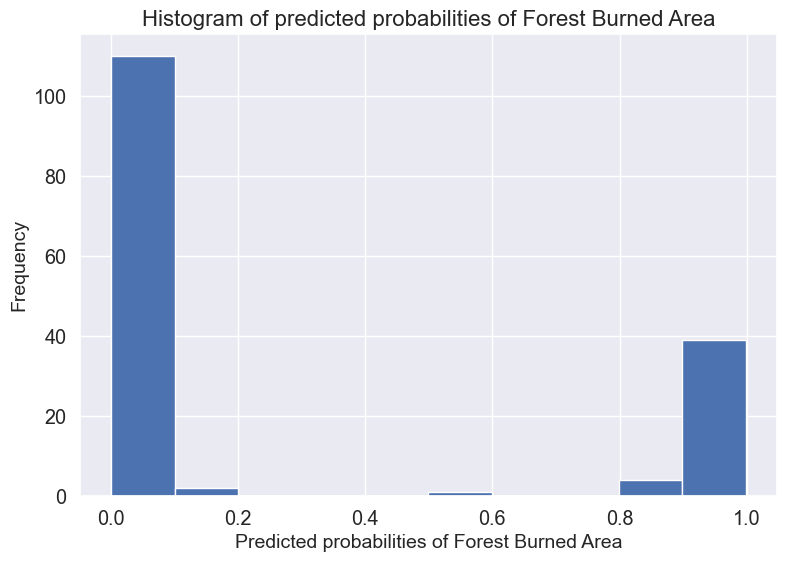

In [98]:
plt.figure(figsize=(9,6))
plt.hist(test_prediction['Test_Probability'], bins = 10)
plt.title('Histogram of predicted probabilities of Forest Burned Area', fontsize=16)
plt.xlabel('Predicted probabilities of Forest Burned Area', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

# 2. Gas Turbine

In [283]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold

from tensorflow import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from keras.models import Sequential
from keras_tuner.tuners import RandomSearch
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

import warnings
warnings.filterwarnings('ignore')

In [284]:
df = pd.read_csv('gas_turbines.csv')
df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311
...,...,...,...,...,...,...,...,...,...,...,...
15034,9.0301,1005.6,98.460,3.5421,19.164,1049.7,546.21,111.61,10.400,4.5186,79.559
15035,7.8879,1005.9,99.093,3.5059,19.414,1046.3,543.22,111.78,10.433,4.8470,79.917
15036,7.2647,1006.3,99.496,3.4770,19.530,1037.7,537.32,110.19,10.483,7.9632,90.912
15037,7.0060,1006.8,99.008,3.4486,19.377,1043.2,541.24,110.74,10.533,6.2494,93.227


In [285]:
df.isnull().any()

AT      False
AP      False
AH      False
AFDP    False
GTEP    False
TIT     False
TAT     False
TEY     False
CDP     False
CO      False
NOX     False
dtype: bool

In [286]:
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [287]:
df.shape

(15039, 11)

In [288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [289]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,15039.0,17.764381,7.574323,0.522300,11.408000,18.1860,23.8625,34.9290
AP,15039.0,1013.199240,6.410760,985.850000,1008.900000,1012.8000,1016.9000,1034.2000
AH,15039.0,79.124174,13.793439,30.344000,69.750000,82.2660,90.0435,100.2000
AFDP,15039.0,4.200294,0.760197,2.087400,3.723900,4.1862,4.5509,7.6106
GTEP,15039.0,25.419061,4.173916,17.878000,23.294000,25.0820,27.1840,37.4020
TIT,15039.0,1083.798770,16.527806,1000.800000,1079.600000,1088.7000,1096.0000,1100.8000
TAT,15039.0,545.396183,7.866803,512.450000,542.170000,549.8900,550.0600,550.6100
TEY,15039.0,134.188464,15.829717,100.170000,127.985000,133.7800,140.8950,174.6100
CDP,15039.0,12.102353,1.103196,9.904400,11.622000,12.0250,12.5780,15.0810
CO,15039.0,1.972499,2.222206,0.000388,0.858055,1.3902,2.1604,44.1030


In [290]:
df.corr()["TEY"].sort_values(ascending=False)

TEY     1.000000
CDP     0.988473
GTEP    0.977042
TIT     0.891587
AFDP    0.717995
AP      0.146939
NOX    -0.102631
AH     -0.110272
AT     -0.207495
CO     -0.541751
TAT    -0.720356
Name: TEY, dtype: float64

In [291]:
numerical_features = df.describe(include=["int64","float64"]).columns
numerical_features

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

# Data Visualization

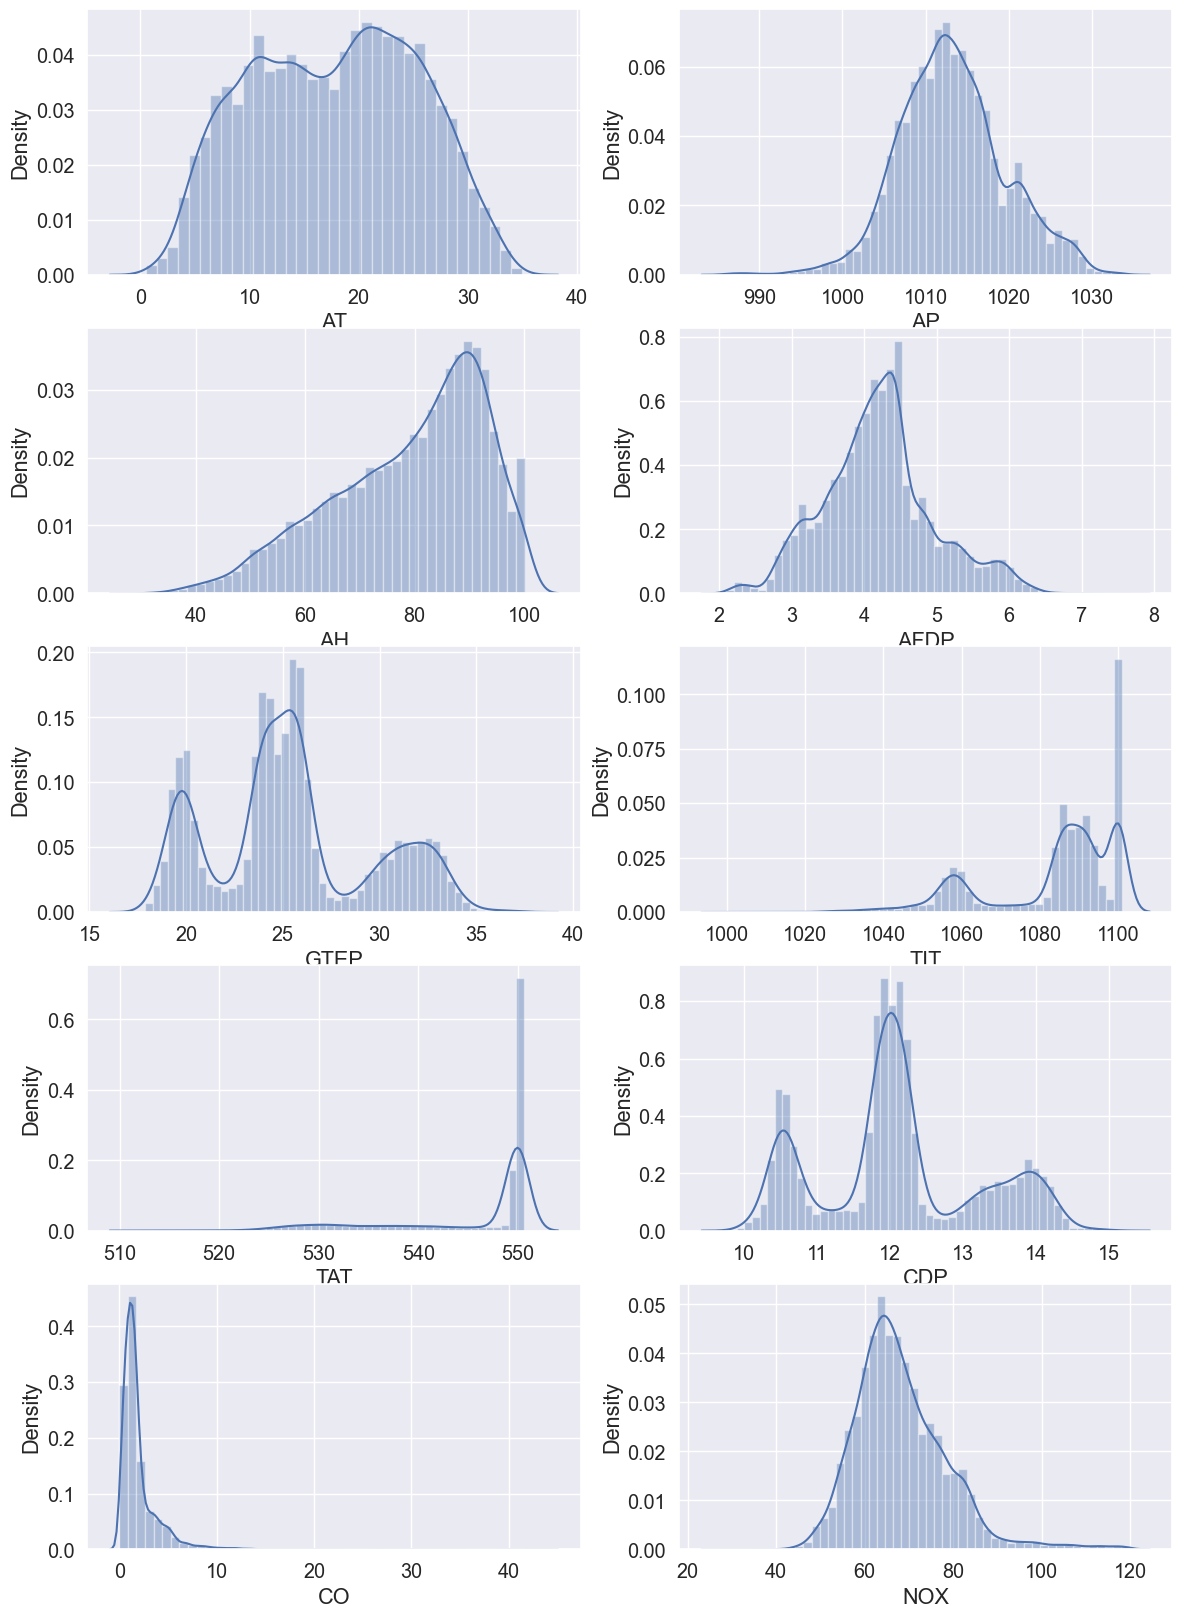

In [292]:
fig, ax = plt.subplots(5,2, figsize = (14,20))

sns.distplot(df.AT, ax = ax[0,0])
sns.distplot(df.AP, ax = ax[0,1])
sns.distplot(df.AH, ax = ax[1,0])
sns.distplot(df.AFDP, ax = ax[1,1])
sns.distplot(df.GTEP, ax = ax[2,0])
sns.distplot(df.TIT, ax = ax[2,1])
sns.distplot(df.TAT, ax = ax[3,0])
sns.distplot(df.CDP, ax = ax[3,1])
sns.distplot(df.CO, ax = ax[4,0])
sns.distplot(df.NOX, ax = ax[4,1])

plt.show()

In [293]:
#Outliers Detection

In [294]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    for col in df.columns.tolist():         # iterate over features(columns)
        Q1 = np.percentile(df[col],25)      # 1st quartile (25%)
        Q3 = np.percentile(df[col],75)      # 3rd quartile (75%)
        IQR = Q3 - Q1                       # Interquartile rrange (IQR)

        outlier_step = 1.5 * IQR            # outlier step
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # Append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # Select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[numerical_features]))))

The dataset contains 1543 observations with more than 2 outliers


In [295]:
numerical_features


Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

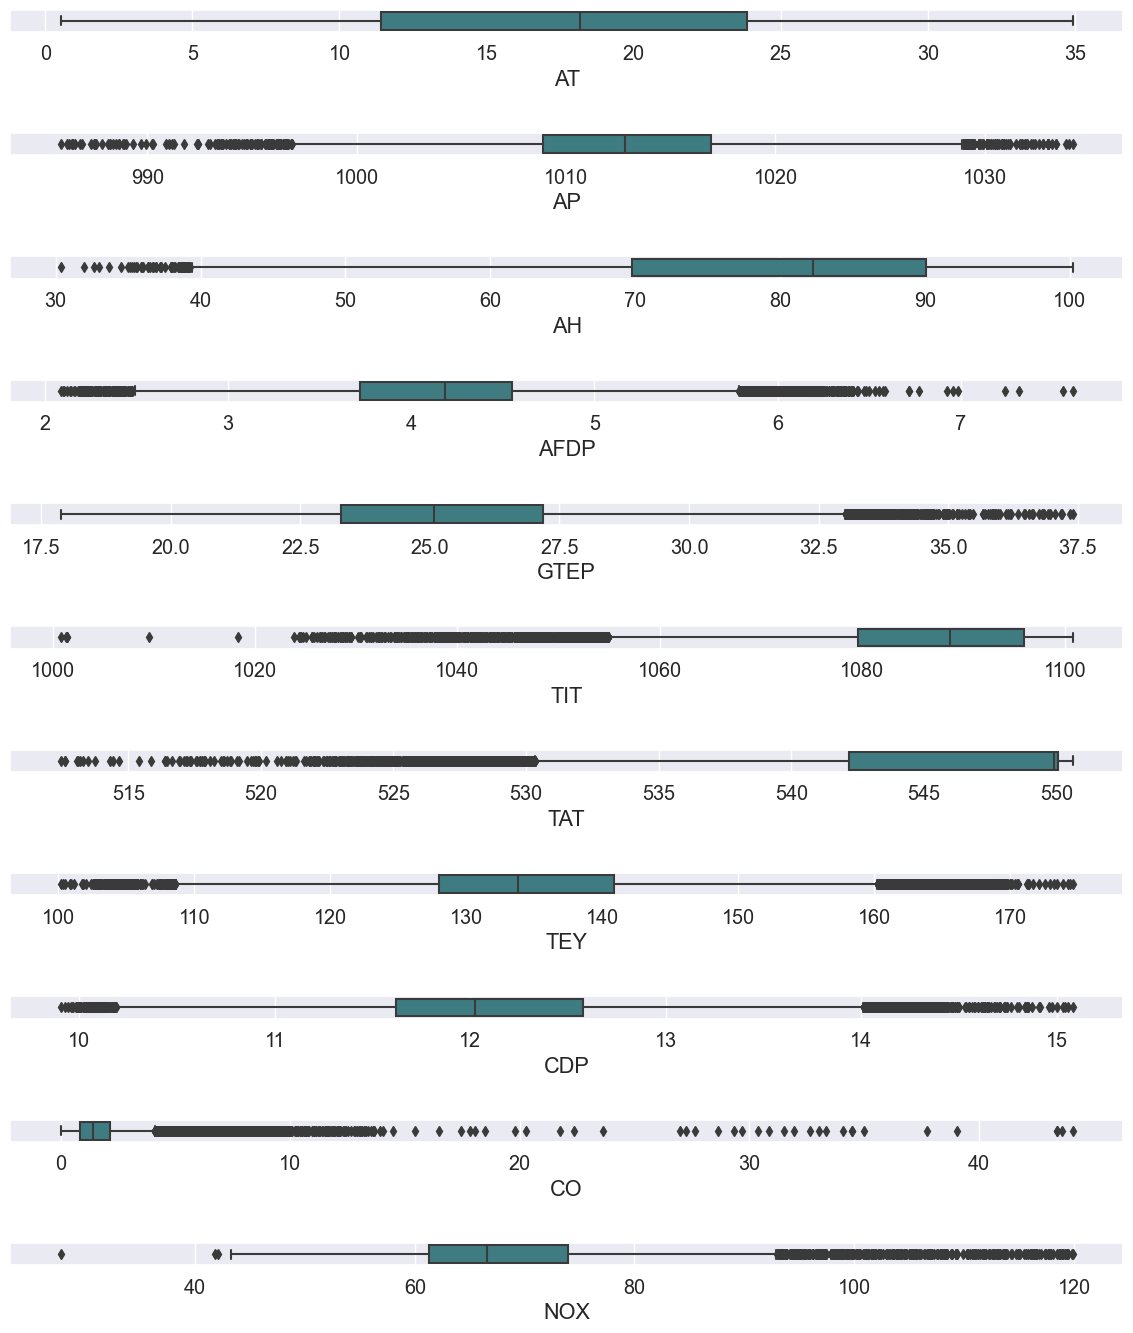

In [296]:
outlier = df.copy() 
fig, axes=plt.subplots(11,1,figsize=(12,14),sharex=False,sharey=False)
sns.boxplot(x='AT',data= outlier,palette='crest',ax=axes[0])
sns.boxplot(x='AP',data= outlier,palette='crest',ax=axes[1])
sns.boxplot(x='AH',data= outlier,palette='crest',ax=axes[2])
sns.boxplot(x='AFDP',data= outlier,palette='crest',ax=axes[3])
sns.boxplot(x='GTEP',data= outlier,palette='crest',ax=axes[4])
sns.boxplot(x='TIT',data= outlier,palette='crest',ax=axes[5])
sns.boxplot(x='TAT',data= outlier,palette='crest',ax=axes[6])
sns.boxplot(x='TEY',data= outlier,palette='crest',ax=axes[7])
sns.boxplot(x='CDP',data= outlier,palette='crest',ax=axes[8])
sns.boxplot(x='CO',data= outlier,palette='crest',ax=axes[9])
sns.boxplot(x='NOX',data= outlier,palette='crest',ax=axes[10])
plt.tight_layout(pad=2.0)

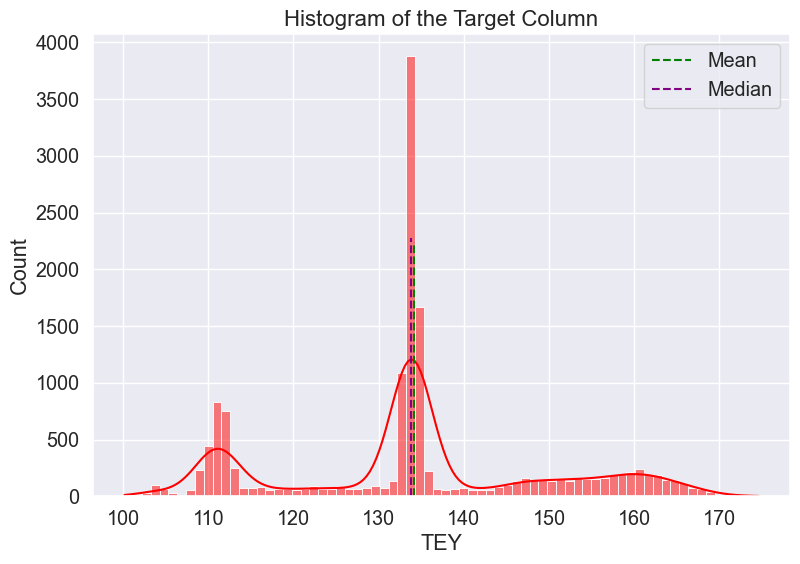

In [297]:
sns.set_style("darkgrid")
plt.figure(figsize=(9,6))
sns.histplot(data= df, x= "TEY", color= "red", kde= True)
plt.axvline(x=df["TEY"].mean(), ymax= 0.55, color= "green", linestyle= '--', label= "Mean")
plt.axvline(x=df["TEY"].median(), ymax= 0.56, color= "purple", linestyle= '--',label= "Median")
plt.title("Histogram of the Target Column", fontsize=16)
plt.legend();

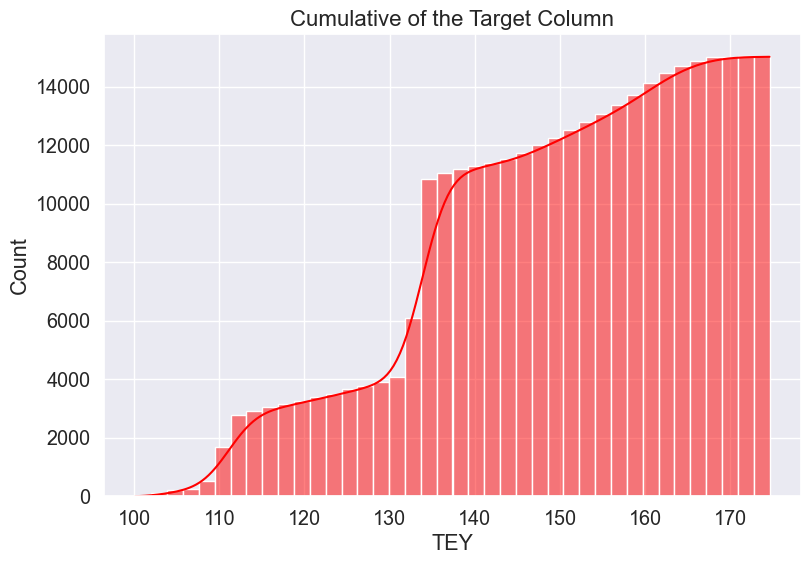

In [298]:
plt.figure(figsize = (9,6))
sns.histplot(df["TEY"], kde= True, bins= 40, color= "red", cumulative= True)
plt.title("Cumulative of the Target Column", fontsize=16);

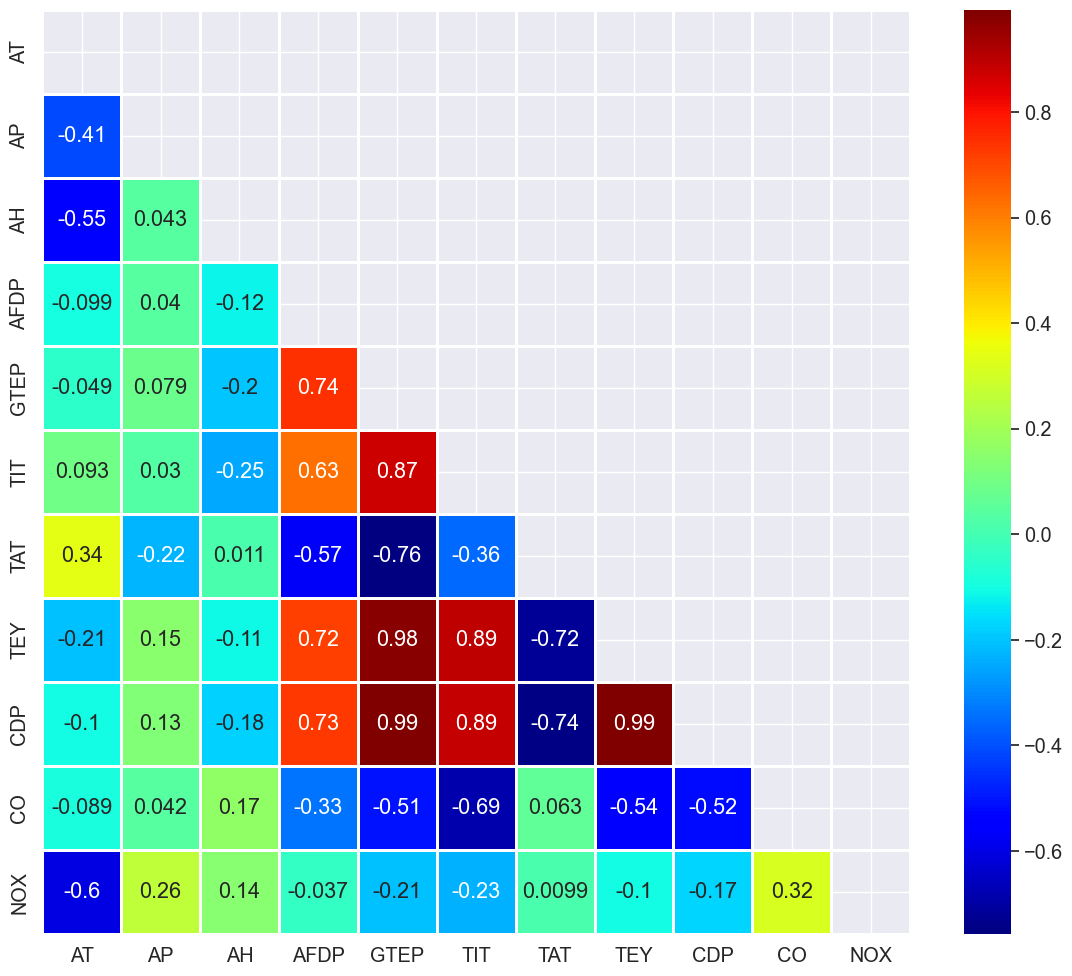

In [299]:
#Correlation Matrix
plt.figure(figsize=(14,12))
mask = np.zeros_like(df.corr(), dtype= np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data= df.corr(), cmap= "jet", annot= True, linewidths= 1, linecolor= 'white', mask=mask);

In [300]:
x = df.drop('TEY', axis=1)
y = df[["TEY"]]

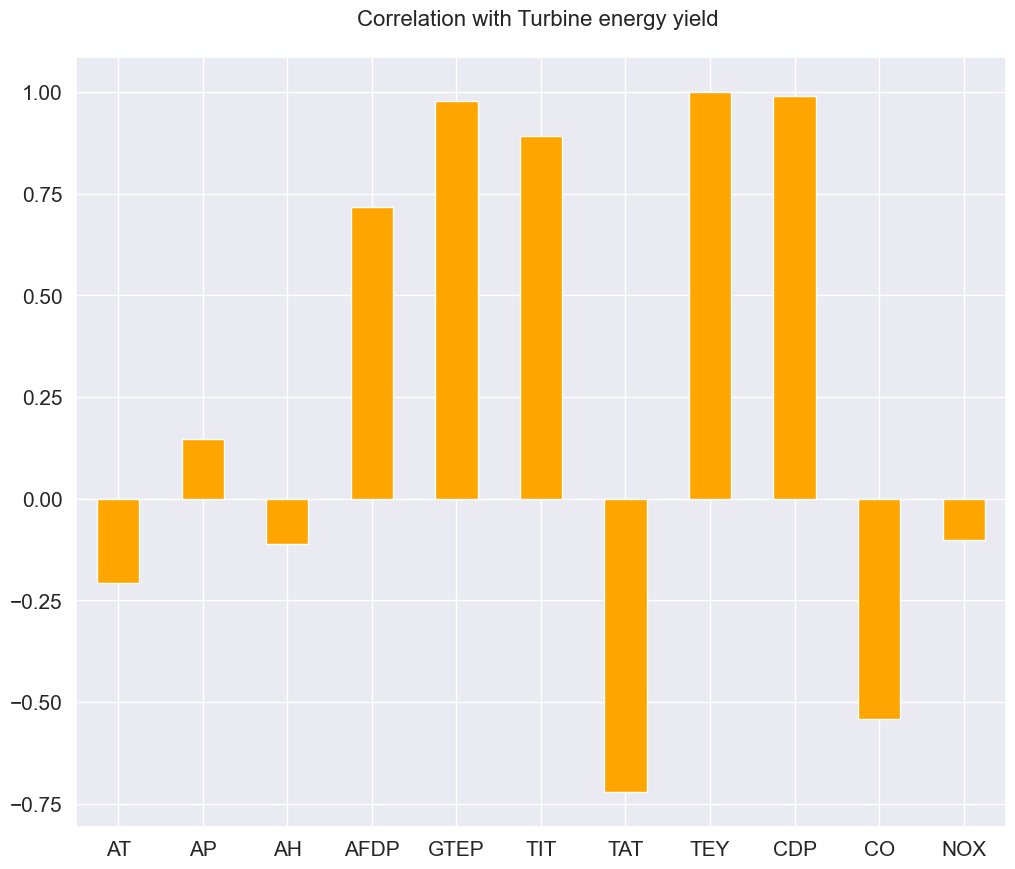

In [301]:
data2 = df.copy()

correlations = data2.corrwith(df.TEY)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations>0].sort_values(ascending = False)
negative_correlations = correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(figsize=(12,10), fontsize = 15, color = 'orange', rot = 0, grid = True)
plt.title('Correlation with Turbine energy yield \n', fontsize = "16", fontfamily = "sans-serif")
plt.show()

# Data Pre Processing

In [302]:
#Feature Selection Technique
from numpy import set_printoptions
from sklearn.feature_selection import mutual_info_regression

In [303]:
#Feature Extraction

In [304]:
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(x, y)

In [305]:
#Summarize score
scores = fit.scores_
features = fit.transform(x)

In [306]:
score_df = pd.DataFrame(list(zip(scores, x.columns)), columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
7,1.713314,CDP
4,1.600079,GTEP
5,1.323958,TIT
6,0.895513,TAT
3,0.660604,AFDP
8,0.511997,CO
0,0.412578,AT
9,0.300766,NOX
1,0.139819,AP
2,0.097729,AH


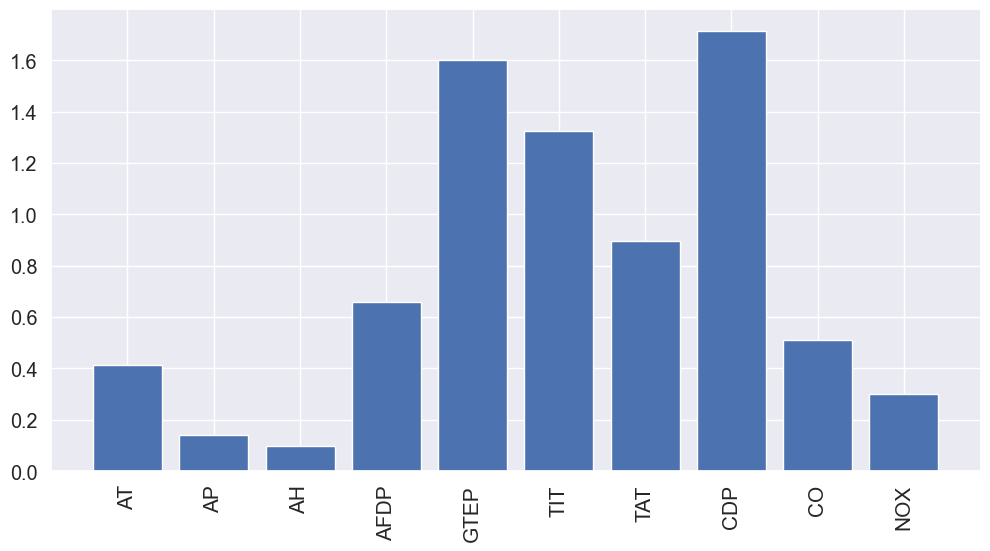

In [307]:
fig, axes = plt.subplots(figsize=(12,6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

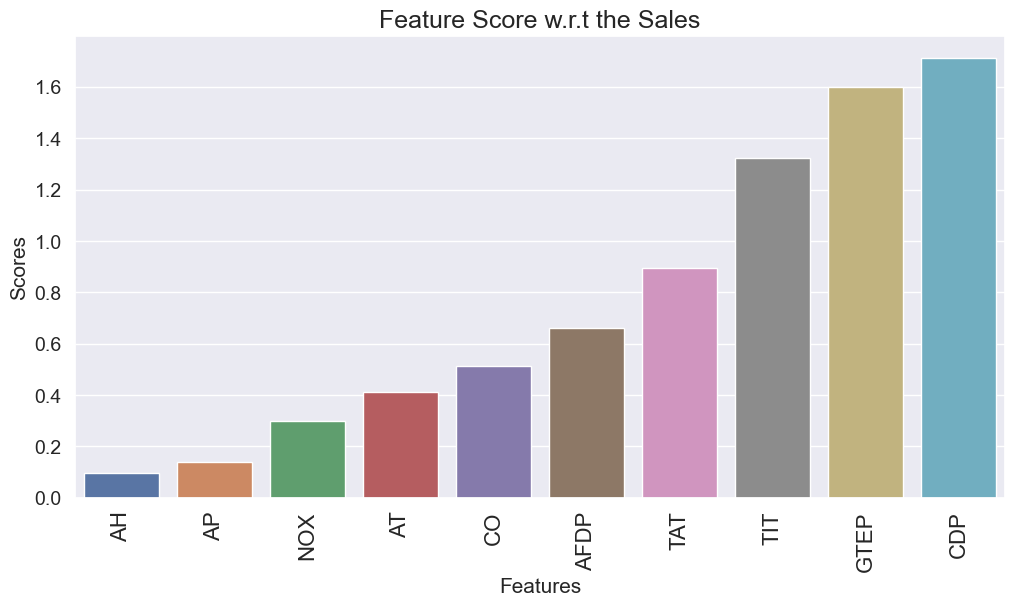

In [308]:
plt.figure(figsize=(12,6))
sns.barplot(x='Feature', y="Score", data=score_df, order=score_df.sort_values('Score').Feature)
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

In [309]:
score_df.sort_values('Score', ascending=False)

,Score,Feature
7,1.713314,CDP
4,1.600079,GTEP
5,1.323958,TIT
6,0.895513,TAT
3,0.660604,AFDP
8,0.511997,CO
0,0.412578,AT
9,0.300766,NOX
1,0.139819,AP
2,0.097729,AH


In [310]:
model_data = df[['CDP', 'GTEP','TIT', 'TAT', 'AFDP', 'CO', 'AT',"TEY"]]
model_data.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72


# Feature Engineering

In [311]:
#Applying Standard Scaler
continuous_feature=[feature for feature in model_data.columns if model_data[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 8


In [312]:
df_standard_scaled = model_data.copy()
features = df_standard_scaled[continuous_feature]

In [313]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,-1.357331,-1.379101,-1.488376,0.585240,-0.921232,0.532012,-1.439778,-1.231172
1,-1.363676,-1.363528,-1.482325,0.585240,-0.921495,0.568733,-1.449601,-1.229909
2,-1.360957,-1.351309,-1.476275,0.568715,-0.944385,0.552938,-1.434721,-1.230541
3,-1.356424,-1.348194,-1.464173,0.583969,-0.946884,0.548933,-1.413702,-1.229909
4,-1.350985,-1.354663,-1.458123,0.582698,-0.924389,0.574179,-1.368693,-1.229909


In [314]:
print('Mean' '\n',np.round(df_standard_scaled.mean(),1))

Mean
 CDP     0.0
GTEP   -0.0
TIT    -0.0
TAT     0.0
AFDP    0.0
CO      0.0
AT      0.0
TEY     0.0
dtype: float64


In [315]:
print('Standard Devaition','\n',np.round(df_standard_scaled.std(),1))

Standard Devaition 
 CDP     1.0
GTEP    1.0
TIT     1.0
TAT     1.0
AFDP    1.0
CO      1.0
AT      1.0
TEY     1.0
dtype: float64


# Test Train Split With Imbalanced Dataset

In [316]:
x = df_standard_scaled.drop('TEY',axis=1)
y = df_standard_scaled[['TEY']]

In [317]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)

# Hyper Parameter Tuning

In [318]:
#Hyperparameter Tuning: Optimal Learning rate ,Number of Layers and Neurons
def build_model(hp):
    model =Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units = hp.Int('units_' + str(i), min_value=32, max_value=100, step=32), activation='relu'))
    
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error', metrics=['mean_absolute_error'])
    return model

In [319]:
from keras_tuner.tuners import RandomSearch

In [320]:
tuner = RandomSearch(build_model, objective= 'val_mean_absolute_error', max_trials= 5,
                     executions_per_trial= 3, directory= 'project', project_name= 'Gas Turbine')
tuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from project\Gas Turbine\tuner0.json
Search space summary
Default search space size: 21
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_5 (Int)
{'default': None, 'conditions': [], 'min_va

In [321]:
tuner.search(x_train, y_train,epochs=100,validation_data=(x_test, y_test))

INFO:tensorflow:Oracle triggered exit


In [322]:
tuner.results_summary()

Results summary
Results in project\Gas Turbine
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 1 summary
Hyperparameters:
num_layers: 9
units_0: 32
units_1: 32
learning_rate: 0.0001
units_2: 64
units_3: 96
units_4: 64
units_5: 32
units_6: 96
units_7: 96
units_8: 64
units_9: 32
units_10: 64
units_11: 32
units_12: 96
Score: 0.024519839013616245

Trial 4 summary
Hyperparameters:
num_layers: 4
units_0: 64
units_1: 64
learning_rate: 0.0001
units_2: 32
units_3: 64
units_4: 64
units_5: 96
units_6: 32
units_7: 96
units_8: 96
units_9: 32
units_10: 32
units_11: 96
units_12: 32
units_13: 32
units_14: 96
units_15: 32
units_16: 64
units_17: 64
units_18: 32
Score: 0.02453945328791936

Trial 2 summary
Hyperparameters:
num_layers: 4
units_0: 32
units_1: 64
learning_rate: 0.0001
units_2: 64
units_3: 96
units_4: 96
units_5: 32
units_6: 32
units_7: 96
units_8: 64
units_9: 64
units_10: 96
units_11: 96
units_12: 64
Score: 0.0245864645888408

Trial 3 summary
Hyperpar

In [323]:
#Hyperparameter Tuning: Optimal Batch_size, Number of Epochs

In [324]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(32,input_dim=7,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(units=1,activation="linear"))
    
    adam=Adam(learning_rate=0.001)
    model1.compile(loss= 'mean_absolute_error', optimizer= adam, metrics= ["mean_absolute_error"])
    return model1

In [325]:
model1     = KerasRegressor(build_fn=create_model,verbose=0)
batch_size = [20,40,50]
epochs     = [50,100,200]
param_grid = dict(batch_size= batch_size, epochs= epochs)
grid = GridSearchCV(estimator= model1, param_grid= param_grid, cv= KFold(), verbose= 10)

In [326]:
grid_result1 = grid.fit(x_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START batch_size=20, epochs=50....................................
[CV 1/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.044 total time=  12.0s
[CV 2/5; 1/9] START batch_size=20, epochs=50....................................
[CV 2/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.032 total time=  12.3s
[CV 3/5; 1/9] START batch_size=20, epochs=50....................................
[CV 3/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.033 total time=  12.3s
[CV 4/5; 1/9] START batch_size=20, epochs=50....................................
[CV 4/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.028 total time=  12.3s
[CV 5/5; 1/9] START batch_size=20, epochs=50....................................
[CV 5/5; 1/9] END ....batch_size=20, epochs=50;, score=-0.027 total time=  12.1s
[CV 1/5; 2/9] START batch_size=20, epochs=100...................................
[CV 1/5; 2/9] END ...batch_size=20, epochs=100;, 

In [327]:
print('Best {}, using {}'.format(grid_result1.best_score_, grid_result1.best_params_))
means  = grid_result1.cv_results_["mean_test_score"]
stds   = grid_result1.cv_results_["std_test_score"]
params = grid_result1.cv_results_["params"]
for mean,stdev,param in zip(means, stds,params):
    print("{}, {} with {}".format(mean, stdev, param))

Best -0.02739650048315525, using {'batch_size': 50, 'epochs': 200}
-0.03271920084953308, 0.005867715814778768 with {'batch_size': 20, 'epochs': 50}
-0.029352771118283272, 0.0019488436614309758 with {'batch_size': 20, 'epochs': 100}
-0.030301421880722046, 0.0022132033736816277 with {'batch_size': 20, 'epochs': 200}
-0.031626345589756966, 0.0036231513898761286 with {'batch_size': 40, 'epochs': 50}
-0.03165101297199726, 0.0030633670939230074 with {'batch_size': 40, 'epochs': 100}
-0.030401159450411795, 0.0025392635944025206 with {'batch_size': 40, 'epochs': 200}
-0.034409723430871966, 0.003985041880135775 with {'batch_size': 50, 'epochs': 50}
-0.030934065207839014, 0.001831699270665064 with {'batch_size': 50, 'epochs': 100}
-0.02739650048315525, 0.0025168238715970273 with {'batch_size': 50, 'epochs': 200}


In [328]:
#Hyperparameter Tuning: Optimal Droupout rate
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(32,input_dim=7,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(units=1,activation="linear"))
    
    adam = Adam(lr=0.001)
    model2.compile(loss= 'mean_absolute_error', optimizer= adam, metrics= ["mean_absolute_error"])
    return model2

In [329]:
model2       = KerasRegressor(build_fn= create_model, batch_size= 40, epochs= 200, verbose= 0)
dropout_rate = [0.0,0.1,0.2,0.3,0.4,0.5]
param_grid   = dict(dropout_rate= dropout_rate)
grid2        = GridSearchCV(estimator= model2, param_grid= param_grid, cv= KFold(), verbose= 10)

In [330]:
grid_result2 = grid2.fit(x_test, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................
[CV 1/5; 1/6] END ............dropout_rate=0.0;, score=-0.029 total time=  26.6s
[CV 2/5; 1/6] START dropout_rate=0.0............................................
[CV 2/5; 1/6] END ............dropout_rate=0.0;, score=-0.029 total time=  25.5s
[CV 3/5; 1/6] START dropout_rate=0.0............................................
[CV 3/5; 1/6] END ............dropout_rate=0.0;, score=-0.032 total time=  25.1s
[CV 4/5; 1/6] START dropout_rate=0.0............................................
[CV 4/5; 1/6] END ............dropout_rate=0.0;, score=-0.032 total time=  25.6s
[CV 5/5; 1/6] START dropout_rate=0.0............................................
[CV 5/5; 1/6] END ............dropout_rate=0.0;, score=-0.032 total time=  25.4s
[CV 1/5; 2/6] START dropout_rate=0.1............................................
[CV 1/5; 2/6] END ............dropout_rate=0.1;, 

In [331]:
print('Best {}, using {}'.format(grid_result2.best_score_, grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds  = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means, stds, params):
    print("{}, {} with {}".format(mean, stdev, param))

Best -0.028710121288895607, using {'dropout_rate': 0.2}
-0.030707474052906036, 0.0013796956387879462 with {'dropout_rate': 0.0}
-0.03024180084466934, 0.004012833418389551 with {'dropout_rate': 0.1}
-0.028710121288895607, 0.003079353057770616 with {'dropout_rate': 0.2}
-0.03046457879245281, 0.0035660895868032485 with {'dropout_rate': 0.3}
-0.028822361677885055, 0.0032911622613472366 with {'dropout_rate': 0.4}
-0.03088245019316673, 0.0048807709026414976 with {'dropout_rate': 0.5}


In [332]:
#Hyperparameter Tuning: Optimal Activation Function and Kernel Initializer
def create_model(activation_function,init):
    model3 = Sequential()
    model3.add(Dense(32,input_dim=7,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(units=1,activation="linear"))
    
    adam = Adam(lr=0.001)
    model3.compile(loss= 'mean_absolute_error', optimizer= adam, metrics= ["mean_absolute_error"])
    return model3

In [333]:
model3 = KerasRegressor(build_fn=create_model, batch_size=40,epochs=200,verbose=0)
activation_function = ['softmax','tanh','relu']
init = ['normal','uniform','zero']
param_grid = dict(activation_function= activation_function, init= init)
grid3 = GridSearchCV(estimator= model3, param_grid= param_grid, cv= KFold(), verbose=10)

In [334]:
grid_result3 = grid3.fit(x_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START activation_function=softmax, init=normal....................
[CV 1/5; 1/9] END activation_function=softmax, init=normal;, score=-0.619 total time=  39.4s
[CV 2/5; 1/9] START activation_function=softmax, init=normal....................
[CV 2/5; 1/9] END activation_function=softmax, init=normal;, score=-0.212 total time=  37.7s
[CV 3/5; 1/9] START activation_function=softmax, init=normal....................
[CV 3/5; 1/9] END activation_function=softmax, init=normal;, score=-0.686 total time=  38.4s
[CV 4/5; 1/9] START activation_function=softmax, init=normal....................
[CV 4/5; 1/9] END activation_function=softmax, init=normal;, score=-0.199 total time=  38.8s
[CV 5/5; 1/9] START activation_function=softmax, init=normal....................
[CV 5/5; 1/9] END activation_function=softmax, init=normal;, score=-0.424 total time=  39.7s
[CV 1/5; 2/9] START activation_function=softmax, init=uniform.........

In [335]:
print('Best {}, using {}'.format(grid_result3.best_score_, grid_result3.best_params_))
means = grid_result3.cv_results_["mean_test_score"]
stds  = grid_result3.cv_results_["std_test_score"]
params = grid_result3.cv_results_["params"]
for mean,stdev,param in zip(means, stds, params):
    print("{}, {} with {}".format(mean, stdev, param))

Best -0.2648824781179428, using {'activation_function': 'softmax', 'init': 'uniform'}
-0.4281569331884384, 0.20111782269652695 with {'activation_function': 'softmax', 'init': 'normal'}
-0.2648824781179428, 0.12624963395788774 with {'activation_function': 'softmax', 'init': 'uniform'}
-0.471539232134819, 0.18465067708610425 with {'activation_function': 'softmax', 'init': 'zero'}
-0.4693381577730179, 0.13762113537103493 with {'activation_function': 'tanh', 'init': 'normal'}
-0.3556152403354645, 0.14994782668833453 with {'activation_function': 'tanh', 'init': 'uniform'}
-0.5663758099079133, 0.15378120933616124 with {'activation_function': 'tanh', 'init': 'zero'}
-0.3034934431314468, 0.15734655331276062 with {'activation_function': 'relu', 'init': 'normal'}
-0.5740996360778808, 0.08885018425085633 with {'activation_function': 'relu', 'init': 'uniform'}
-0.5682257950305939, 0.21325622579713882 with {'activation_function': 'relu', 'init': 'zero'}


# Model Building Neural Networks

In [336]:
#Standardizing only predictor variable - after train test split
model_data

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72
...,...,...,...,...,...,...,...,...
15034,10.400,19.164,1049.7,546.21,3.5421,4.5186,9.0301,111.61
15035,10.433,19.414,1046.3,543.22,3.5059,4.8470,7.8879,111.78
15036,10.483,19.530,1037.7,537.32,3.4770,7.9632,7.2647,110.19
15037,10.533,19.377,1043.2,541.24,3.4486,6.2494,7.0060,110.74


In [337]:
#Assigning predictor variables to x and response variable to y
x = model_data.drop('TEY', axis=1)
y = model_data[["TEY"]]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=42)

scaler_train = StandardScaler()
scaler_test = StandardScaler()

x_train_scaled = scaler_train.fit_transform(x_train) # scaling train data -- predictor
x_test_scaled  = scaler_test.fit_transform(x_test)   # scaling test data -- predictor

print("x_train_scaled :", x_train_scaled.shape)
print("x_test_scaled  :",x_test_scaled.shape)
print("y_train        :",y_train.shape)
print("y_test         :",y_test.shape)

x_train_scaled : (12031, 7)
x_test_scaled  : (3008, 7)
y_train        : (12031, 1)
y_test         : (3008, 1)


In [338]:
#Since we have continuous ouput, AF is not required in the o/p layer
model = Sequential()
model.add( Dense(units= 50, activation= 'relu', kernel_initializer= 'normal', input_dim= 7)) # input layer
model.add( Dense(units= 20, activation= 'tanh', kernel_initializer= 'normal')) # hidden layer
model.add( Dense(units= 1, kernel_initializer= 'normal' )) # o/p layer

model.compile(optimizer= "adam", loss= "mse", metrics= ["mae", "mse"])
history = model.fit(x_train_scaled, y_train, batch_size= 50, validation_split= 0.3, epochs=10,  verbose=1)

Epoch 1/10
169/169 [==============================] - 1s 3ms/step - loss: 17665.3438 - mae: 131.9491 - mse: 17665.3438 - val_loss: 16817.4473 - val_mae: 128.7221 - val_mse: 16817.4473
Epoch 2/10
169/169 [==============================] - 0s 2ms/step - loss: 16317.0625 - mae: 126.7420 - mse: 16317.0625 - val_loss: 15757.5771 - val_mae: 124.5374 - val_mse: 15757.5781
Epoch 3/10
169/169 [==============================] - 0s 2ms/step - loss: 15337.9043 - mae: 122.8208 - mse: 15337.9043 - val_loss: 14837.1348 - val_mae: 120.7855 - val_mse: 14837.1348
Epoch 4/10
169/169 [==============================] - 0s 3ms/step - loss: 14451.6943 - mae: 119.1580 - mse: 14451.6943 - val_loss: 13983.4434 - val_mae: 117.1984 - val_mse: 13983.4434
Epoch 5/10
169/169 [==============================] - 0s 2ms/step - loss: 13621.7705 - mae: 115.6229 - mse: 13621.7705 - val_loss: 13178.0801 - val_mae: 113.7106 - val_mse: 13178.0801
Epoch 6/10
169/169 [==============================] - 0s 2ms/step - loss: 12836.

In [363]:
def toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test):
        
    # Defining list of hyperparameters
    batch_size_list = [10 , 15 , 20 ]
    epoch_list      = [10 , 50 , 100]
     
    bestParamTable = pd.DataFrame()
    
    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:
            
            # Create ANN model
            model = Sequential()
            
            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=x_train_scaled.shape[1], kernel_initializer='normal', activation='relu'))
            
            # Defining the Second layer of the model
            model.add(Dense(units=20, kernel_initializer='normal', activation='tanh'))
 
            # The output neuron is a single fully connected node Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(optimizer ='adam', loss = 'mean_squared_error')
            
            # Fitting the ANN to the Training set
            model.fit(x_train_scaled, y_train , batch_size=batch_trial, epochs=epochs_trial,  verbose=0)
                        
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(x_test_scaled))/y_test))  
                        
            bestParamTable=bestParamTable.append(pd.DataFrame(data=[[batch_trial, epochs_trial, 100-MAPE]], columns=['batchsize','epochs','Accuracy'] ))
            
            # Printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:', epochs_trial, 'Accuracy:', 100-MAPE)

    return bestParamTable


finalParamTable = toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test)

94/94 [==============================] - 0s 1ms/step
batch_size: 10 - epochs: 10 Accuracy: TEY    98.520929
dtype: float64
94/94 [==============================] - 0s 966us/step
batch_size: 10 - epochs: 50 Accuracy: TEY    99.682179
dtype: float64
94/94 [==============================] - 0s 999us/step
batch_size: 10 - epochs: 100 Accuracy: TEY    99.644872
dtype: float64
94/94 [==============================] - 0s 968us/step
batch_size: 15 - epochs: 10 Accuracy: TEY    89.835654
dtype: float64
94/94 [==============================] - 0s 975us/step
batch_size: 15 - epochs: 50 Accuracy: TEY    99.646518
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 15 - epochs: 100 Accuracy: TEY    99.68515
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 20 - epochs: 10 Accuracy: TEY    80.948847
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 20 - epochs: 50 Accuracy: TEY    99.549996
dtype: float64
94/94 [

In [365]:
#Training Model - using best params
model.compile(optimizer ='adam', loss = 'mean_squared_error')
model.fit(x_train_scaled,y_train, batch_size= 20, epochs= 10, verbose= 0)

#  Model Evaluation Train and Test Error

In [366]:
# generating predictions for test data
y_predict_test = model.predict(x_test_scaled) 

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)

94/94 [==============================] - 0s 1ms/step
(3008, 9)


,CDP,GTEP,TIT,TAT,AFDP,CO,AT,Actual,Predicted
13312,12.219,25.762,1092.5,550.25,4.0023,1.26430,24.0930,134.46,134.402222
12627,10.791,20.085,1059.6,549.94,3.2106,2.69370,20.4500,111.88,112.081039
6393,12.126,25.221,1089.9,549.62,4.5325,1.96250,20.2620,133.72,134.052734
4990,12.218,25.965,1092.9,549.96,4.4266,1.57120,26.8620,133.79,133.807098
12462,10.466,19.688,1056.9,550.01,3.1241,2.29960,19.4090,110.77,110.960472
7405,10.624,19.387,1058.9,550.17,3.3709,4.27640,2.2158,113.32,114.876259
10993,12.088,25.392,1089.7,550.11,3.7871,0.83578,23.8520,133.77,133.305542
9488,11.498,23.225,1079.4,549.60,4.2837,2.01980,12.3950,128.98,129.183624
14201,13.971,32.518,1100.1,528.98,5.1559,0.87760,12.3590,159.42,160.358398
9757,13.862,32.105,1100.0,530.69,5.9309,10.75000,8.6376,161.86,159.832703


In [367]:
predictions_df.drop(['CDP','GTEP','TIT','TAT','AFDP','CO','AT'], axis= 1 , inplace= True)

# Calculating Absolute Percent Error and Error

In [368]:
# Computing the absolute percent error
APE = 100*(abs(predictions_df['Actual']-predictions_df['Predicted'])/predictions_df['Actual'])
print('The Accuracy for Test Data -- ANN model = ', 100-np.mean(APE))

# adding absolute percent error to table
predictions_df['APE %'] = APE
predictions_df.head()

The Accuracy for Test Data -- ANN model =  99.63169559482883


,Actual,Predicted,APE %
13312,134.46,134.402222,0.042971
12627,111.88,112.081039,0.179692
6393,133.72,134.052734,0.248829
4990,133.79,133.807098,0.012780
12462,110.77,110.960472,0.171953


In [369]:
predictions_df['Error'] = (predictions_df['Actual'] - predictions_df['Predicted'])/(predictions_df['Actual'])
predictions_df.reset_index(drop = True)

,Actual,Predicted,APE %,Error
0,134.46,134.402222,0.042971,0.000430
1,111.88,112.081039,0.179692,-0.001797
2,133.72,134.052734,0.248829,-0.002488
3,133.79,133.807098,0.012780,-0.000128
4,110.77,110.960472,0.171953,-0.001720
...,...,...,...,...
3003,119.25,119.176056,0.062008,0.000620
3004,133.74,133.890915,0.112842,-0.001128
3005,146.31,146.205200,0.071629,0.000716
3006,150.07,150.066925,0.002049,0.000020


In [370]:
#Visualizing the Relationship between the Actual and Predicted ValuesModel Validation

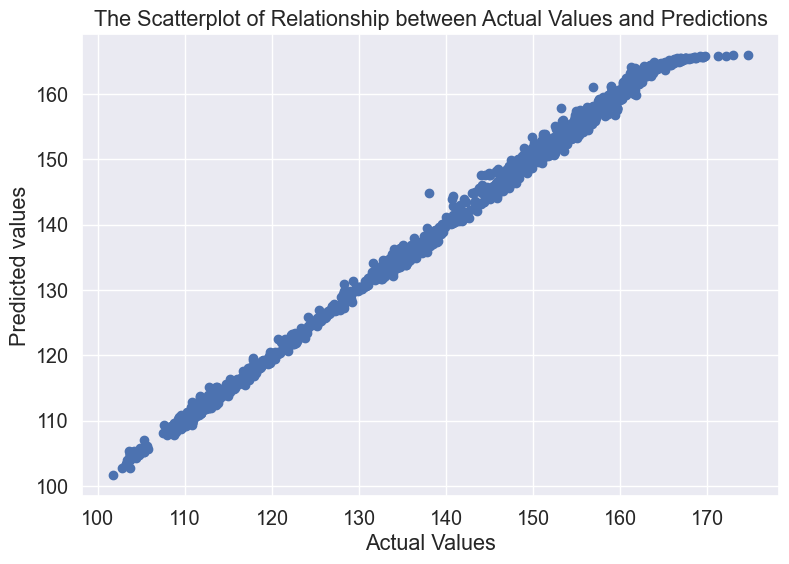

In [371]:
plt.figure(figsize=(9,6))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'])

In [372]:
#We will evaluate our model performance by calculating the residual sum of squares and the explained variance score

In [373]:
from sklearn import metrics
print("MAE  :",metrics.mean_absolute_error(y_test,y_predict_test))
print("MSE  :",metrics.mean_squared_error(y_test,y_predict_test))
print("RMSE :",np.sqrt(metrics.mean_squared_error(y_test,y_predict_test)))

MAE  : 0.5044610788467085
MSE  : 0.5833491456298623
RMSE : 0.7637729673337897


In [374]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict_test = model.predict(x_test_scaled)
y_predict_train = model.predict(x_train_scaled) 
print('R2_score (train) : ',r2_score(y_train, y_predict_train))
print('R2_score (test)  : ',r2_score(y_test, y_predict_test))

376/376 [==============================] - 0s 925us/step
R2_score (train) :  0.9975041969402296
R2_score (test)  :  0.9976702342895151


In [375]:
#Evaluation of the explained variance score (R^2)

In [376]:
print('This shows our model predict % {} of the target correctly'.format(np.round(metrics.explained_variance_score(y_test,y_predict_test)*100,2))) 

This shows our model predict % 99.77 of the target correctly


In [377]:
#Residual Analysis
#Test for Normality of Residuals (Q-Q Plot)

<Axes: ylabel='Density'>

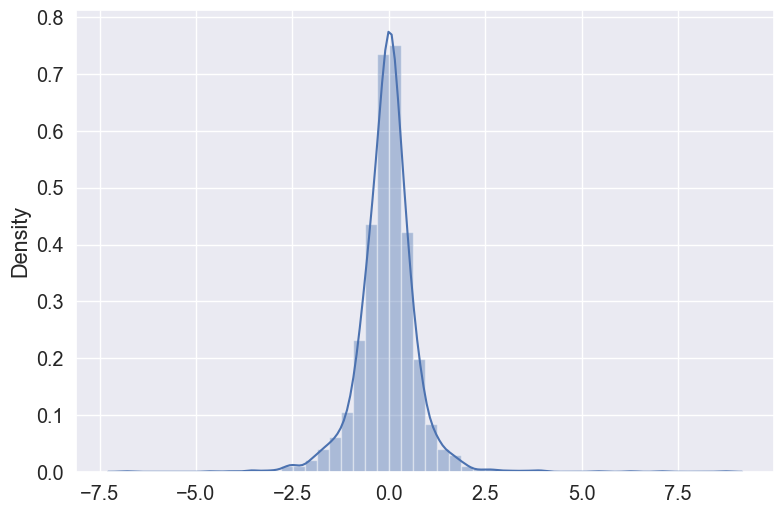

In [378]:
# Now we will visualize the differences between our predictions and actual y test data
plt.figure(figsize=(9,6))
sns.distplot(y_test-y_predict_test,bins=50) # this figure also proves that our model fits very good

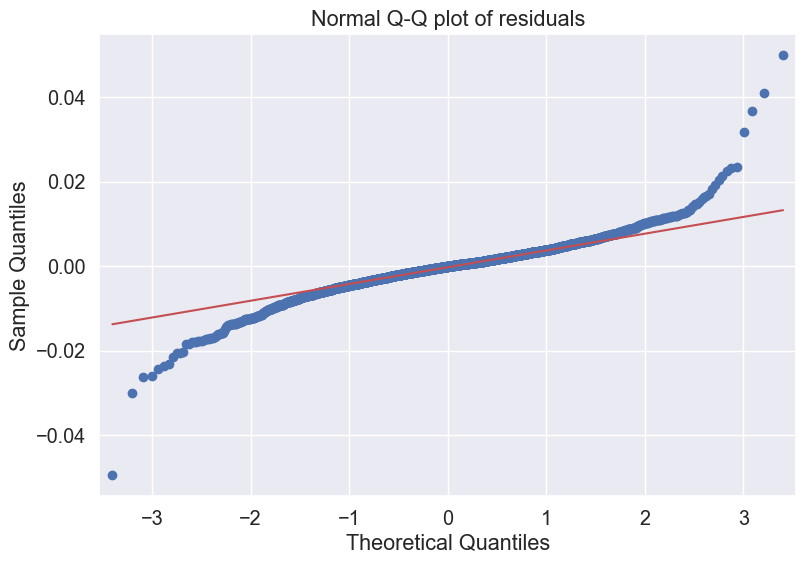

In [379]:
import statsmodels.api as smf
plt.rcParams["figure.figsize"] = (9,6)
smf.qqplot(predictions_df['Error'], line= 'q')
plt.title('Normal Q-Q plot of residuals')
plt.show()


In [ ]:
#Error should have Normal / Gaussian distribution~N(0,1) and independently and identically distributed.